In [109]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
#from utils import Logger

In [110]:
print(torch.cuda.is_available())

True


In [111]:
#download 60,000 black and white mnist images each containing 28x28 pixels
def mnist_data():
    compose = transforms.Compose(#composes several transforms together
        [transforms.ToTensor(),#converts HxWxC image to CxHxW in the range [0,1]
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))#Normalises the tensor to [-1,1] for each channel
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
#root– Root directory of dataset where processed/training.pt and processed/test.pt exist.
#train-If True, creates dataset from training.pt, otherwise from test.pt.
#download-If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.
#transform– A function/transform that takes in an PIL image and returns a transformed version.
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
#dataloader provides iterators over the dataset
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [112]:
# class DiscriminatorNet(torch.nn.Module):
#     """
#     A three hidden-layer discriminative neural network
#     """
#     def __init__(self):
#         super(DiscriminatorNet, self).__init__()
#         n_features = 784 #28x28
#         n_out = 1
        
#         #nn.Sequential makes a sequential container
#         self.hidden0 = nn.Sequential( 
#             nn.Linear(n_features, 1024),#linear transformation
#             nn.LeakyReLU(0.2),#0.2 negative slope
#             nn.Dropout(0.3)
#         )
#         self.hidden1 = nn.Sequential(
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3)
#         )
#         self.hidden2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3)
#         )
#         self.out = nn.Sequential(
#             torch.nn.Linear(256, n_out),
#             #torch.nn.Sigmoid()#sigmoid as we have to do a binary classification
#         )

#     def forward(self, x): #does forward propagation
#         x = self.hidden0(x)
#         x = self.hidden1(x)
#         x = self.hidden2(x)
#         x = self.out(x)
#         return x
# discriminator = DiscriminatorNet()

In [113]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28) #(batch size,no. of channels,28,28)

In [114]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh() #tanh is in [-1,1], which is the range of normalized input data
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet().cuda()

In [115]:
#function to generate noise samples
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values from standard normal dostribution. shape=(size,100)
    '''
    n = Variable(torch.randn(size, 100,device='cuda')) #Variable wraps a tensor and has backward method for backpropagation
    return n

#function to generate random vector of size 1. Each component of the vector is from a
#standard normal distribution so that the vectors are uniformly distributed over the unit sphere

def make_rand_vec(dims):
    #vec = [gauss(0, 1) for i in range(dims)]
    vec = torch.randn(dims,device='cuda')
    
    mag = sum(x**2 for x in vec) ** .5
    return torch.reshape(torch.tensor([x/mag for x in vec]),(dims,1))



In [116]:
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002) #lr=learning rate
g_optimizer = (optim.Adam(generator.parameters(), lr=0.0002))
#g_optimizer=g_optimizer.cuda()
#g_optimizer = optim.SGD(generator.parameters(), lr=0.0002)
#d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0002)

In [117]:
#loss = nn.BCELoss()

In [118]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1,device='cuda'))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1,device='cuda'))
    return data

In [119]:
# def train_discriminator(optimizer, real_data, fake_data):
#     N = real_data.size(0)
#     # Reset gradients
#     optimizer.zero_grad()
    
#     # 1.1 Train on Real Data
#     prediction_real = discriminator(real_data)
#     # Calculate error and backpropagate
#     #error_real = loss(prediction_real, ones_target(N) )
#     #error_real.backward()

#     # 1.2 Train on Fake Data
#     prediction_fake = discriminator(fake_data)
#     # Calculate error and backpropagate
#     #error_fake = loss(prediction_fake, zeros_target(N))
#     #error_fake.backward()
    
#     #Calculate error based on wasserstein distance
#     error = -(torch.mean(prediction_real) - torch.mean(prediction_fake)) #loss function for discriminator
#     error.backward()
    
    
#     # 1.3 Update weights with gradients
#     optimizer.step()
    
#     #clamp the weights for lipchitz continuity
#     for p in discriminator.parameters():
#             p.data.clamp_(-0.01, 0.01)
    
#     # Return error and predictions for real and fake inputs
#     return error, prediction_real, prediction_fake

In [120]:
def train_generator(optimizer, real_data, fake_data):
    N = fake_data.size(0)
    
    # Reset gradients
    optimizer.zero_grad()
    error=0;
    num_projection_directions=1000
    # Sample noise and generate fake data
    #prediction = discriminator(fake_data)#check if detach has to be added here
    # Calculate error and backpropagate
    #error = loss(prediction, ones_target(N))
    for npd in (range(num_projection_directions)):
        unit_vector = make_rand_vec(fake_data.size(1)).cuda()
    
#         print(projected_real_data.size(0))
#         print(projected_real_data.size(1))
#         print(projected_fake_data.size(1))
#         print(projected_fake_data.size(0))
        
        projected_real_data = torch.mm(real_data, unit_vector)
        #print(projected_real_data.shape)
        projected_fake_data = torch.mm(fake_data, unit_vector)
#         print(projected_real_data.size(0))
#         print(projected_real_data.size(1))
#         print(projected_fake_data.size(1))
#         print(projected_fake_data.size(0))
        
        projected_real_data = torch.sort(projected_real_data,0)[0]
        projected_fake_data = torch.sort(projected_fake_data,0)[0]
        
        error += ((torch.dist(projected_real_data, projected_fake_data, 2)) ** 2) / N
        
    error /= num_projection_directions
    
        
        
        
    #error = -torch.mean(prediction)
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error


In [121]:
num_test_samples = 16
test_noise = noise(num_test_samples)

tensor(0.8829, device='cuda:0', grad_fn=<DivBackward0>)


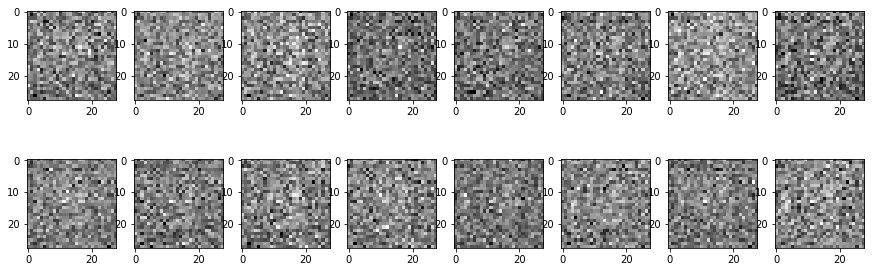

tensor(0.8750, device='cuda:0', grad_fn=<DivBackward0>)


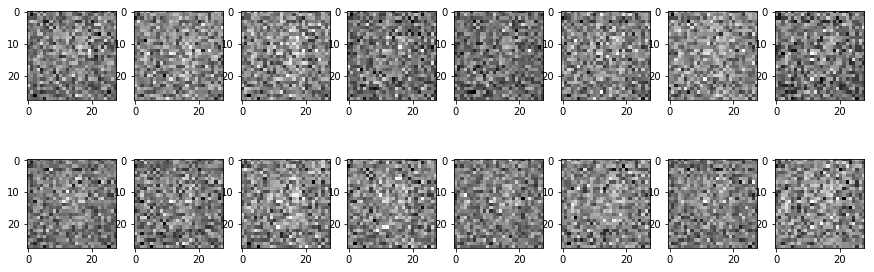

tensor(0.8310, device='cuda:0', grad_fn=<DivBackward0>)


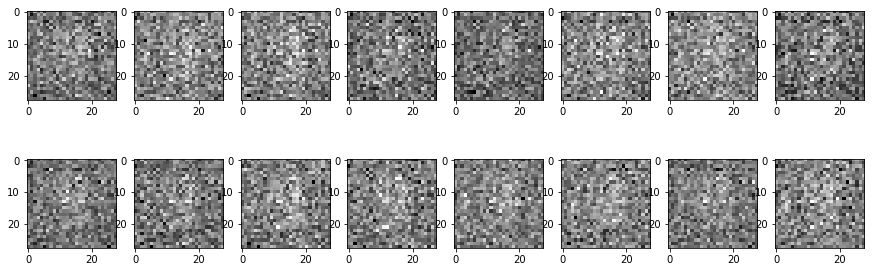

tensor(0.8459, device='cuda:0', grad_fn=<DivBackward0>)


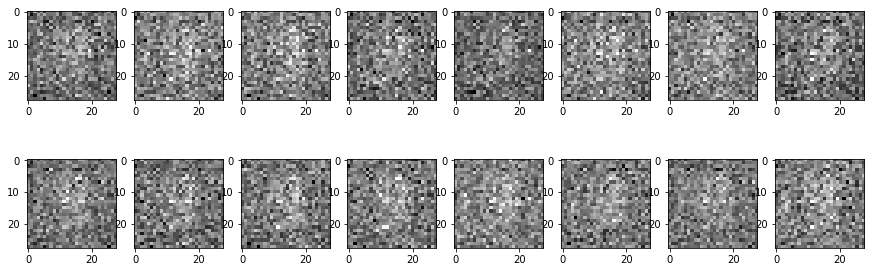

tensor(0.8323, device='cuda:0', grad_fn=<DivBackward0>)


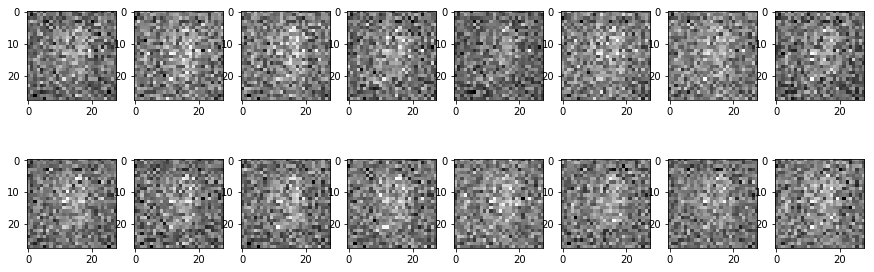

tensor(0.8289, device='cuda:0', grad_fn=<DivBackward0>)


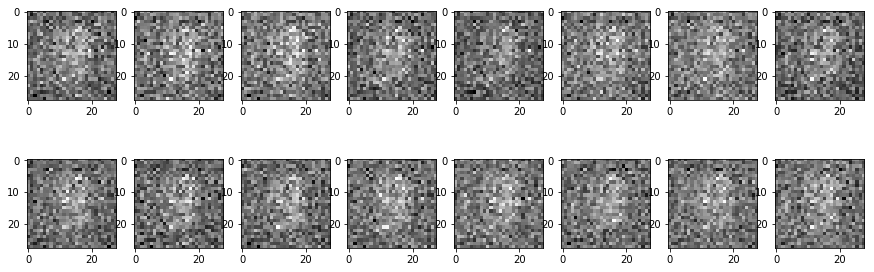

tensor(0.7125, device='cuda:0', grad_fn=<DivBackward0>)


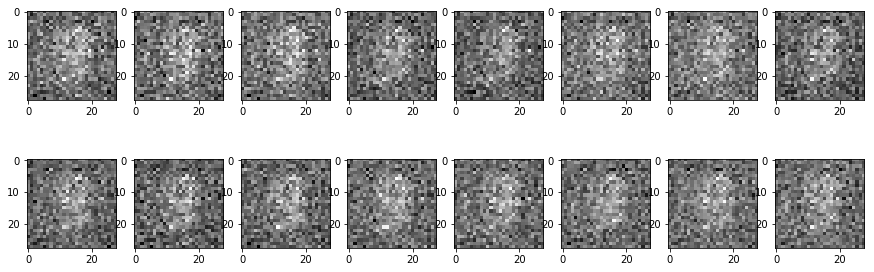

tensor(0.7399, device='cuda:0', grad_fn=<DivBackward0>)


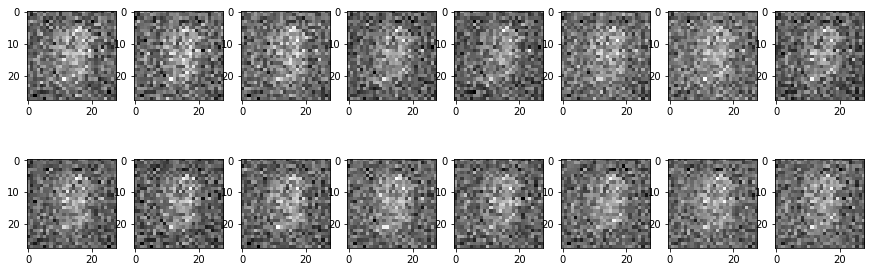

tensor(0.7326, device='cuda:0', grad_fn=<DivBackward0>)


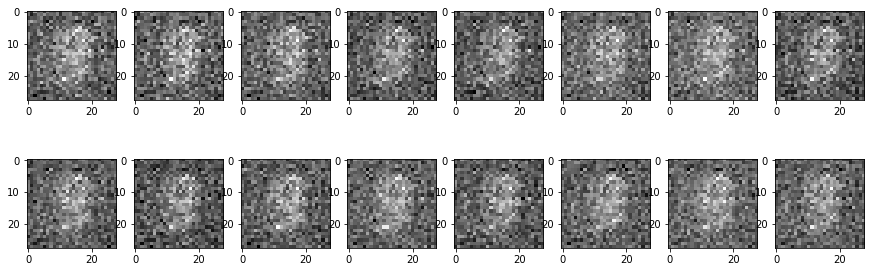

tensor(0.6907, device='cuda:0', grad_fn=<DivBackward0>)


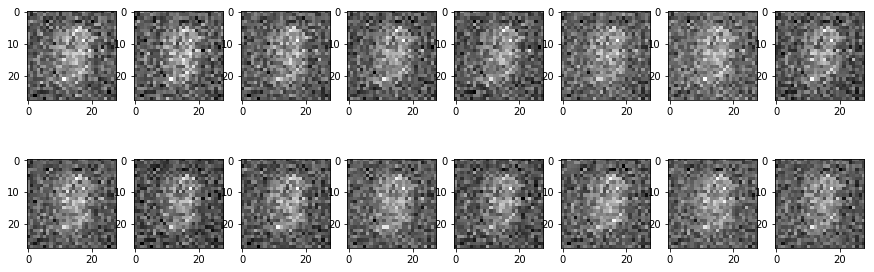

tensor(0.6645, device='cuda:0', grad_fn=<DivBackward0>)


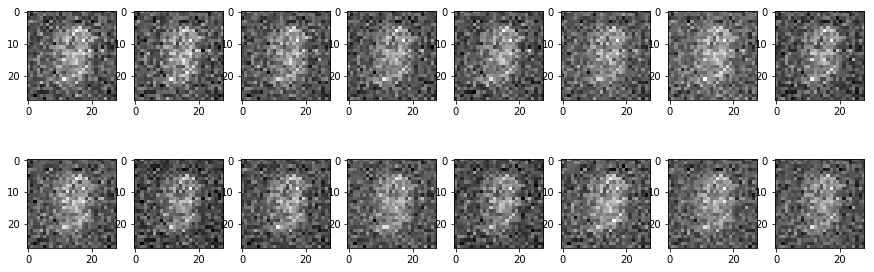

tensor(0.6285, device='cuda:0', grad_fn=<DivBackward0>)


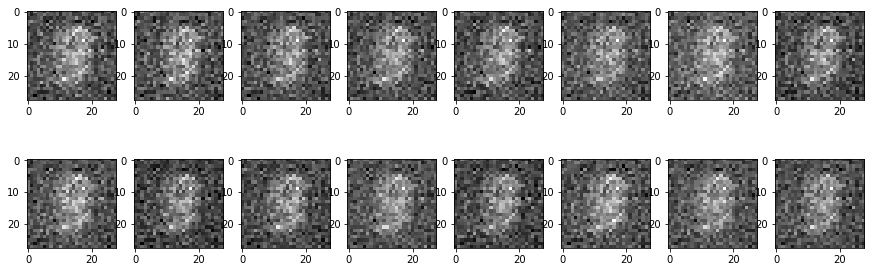

tensor(0.5866, device='cuda:0', grad_fn=<DivBackward0>)


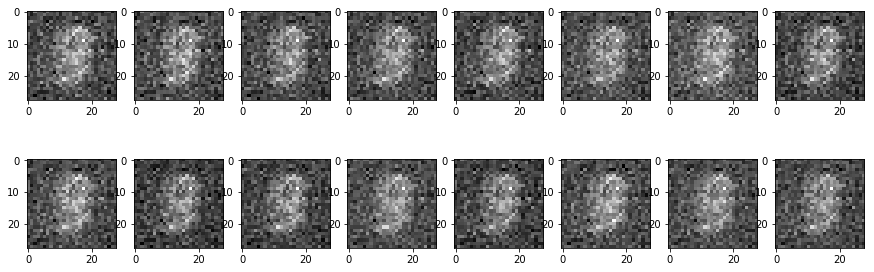

tensor(0.5599, device='cuda:0', grad_fn=<DivBackward0>)


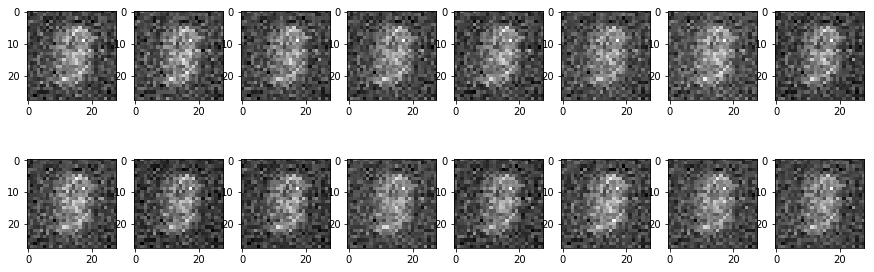

tensor(0.4896, device='cuda:0', grad_fn=<DivBackward0>)


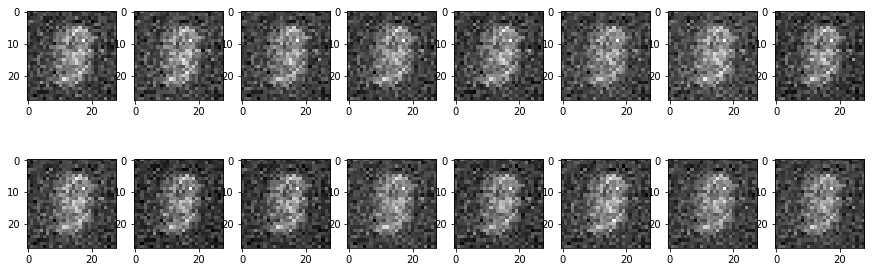

tensor(0.4254, device='cuda:0', grad_fn=<DivBackward0>)


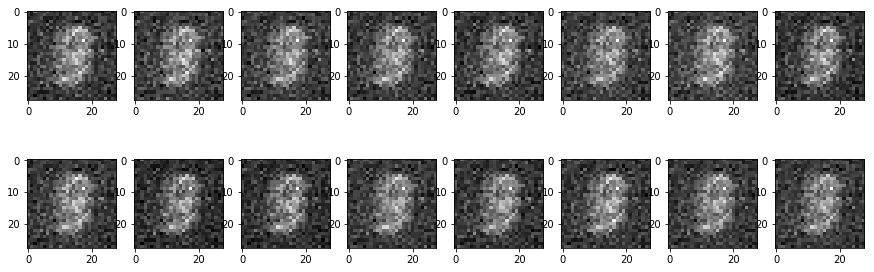

tensor(0.3923, device='cuda:0', grad_fn=<DivBackward0>)


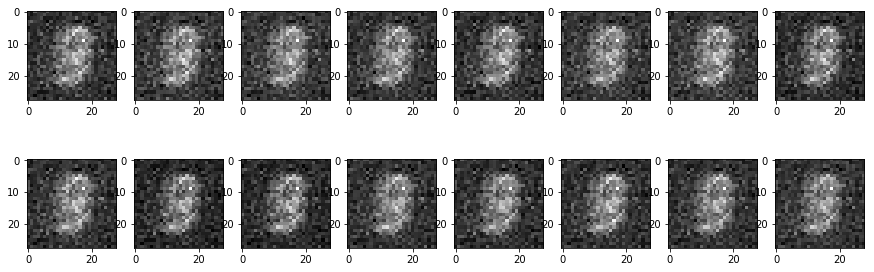

tensor(0.3512, device='cuda:0', grad_fn=<DivBackward0>)


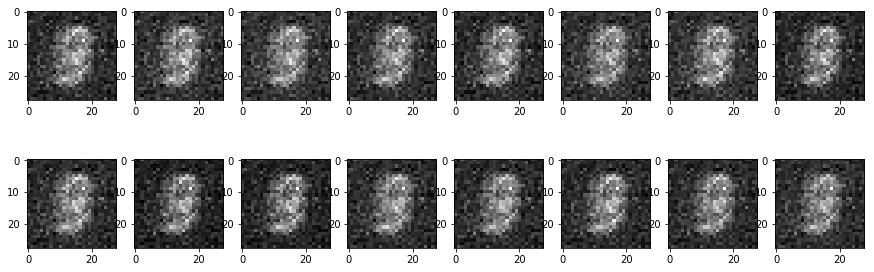

tensor(0.3230, device='cuda:0', grad_fn=<DivBackward0>)


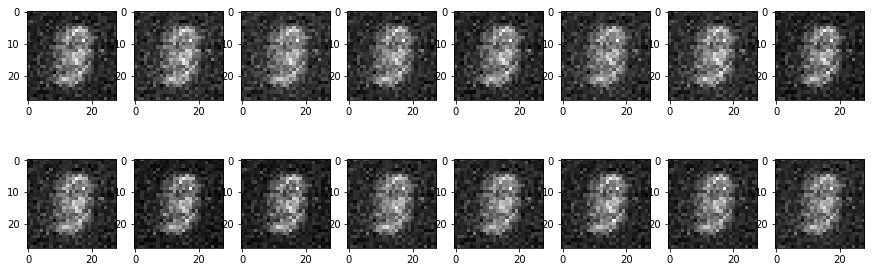

tensor(0.2803, device='cuda:0', grad_fn=<DivBackward0>)


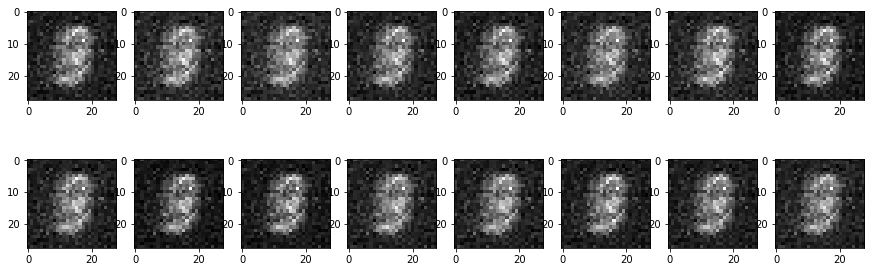

tensor(0.2707, device='cuda:0', grad_fn=<DivBackward0>)


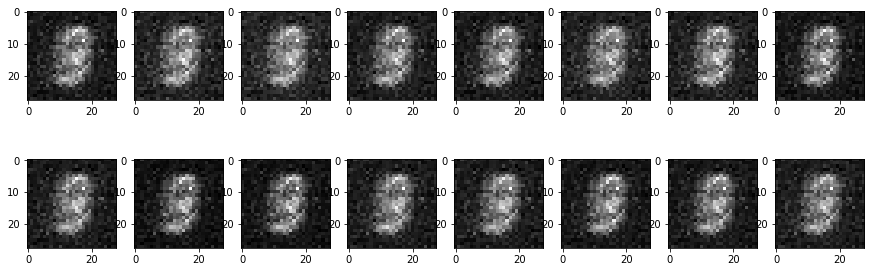

tensor(0.2642, device='cuda:0', grad_fn=<DivBackward0>)


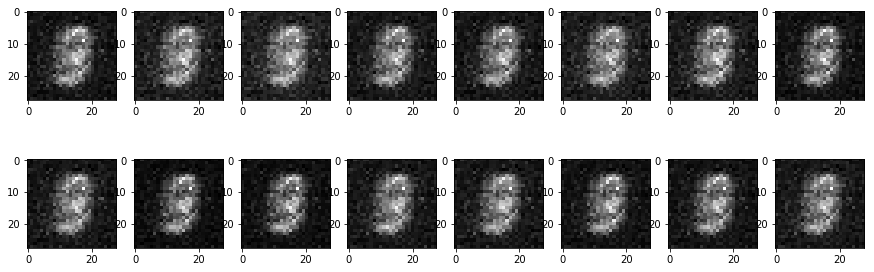

tensor(0.2480, device='cuda:0', grad_fn=<DivBackward0>)


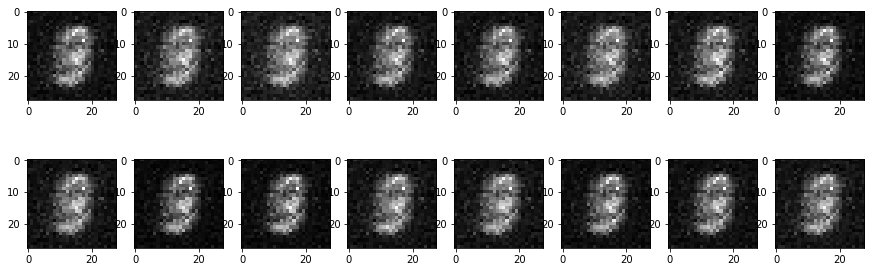

tensor(0.2445, device='cuda:0', grad_fn=<DivBackward0>)


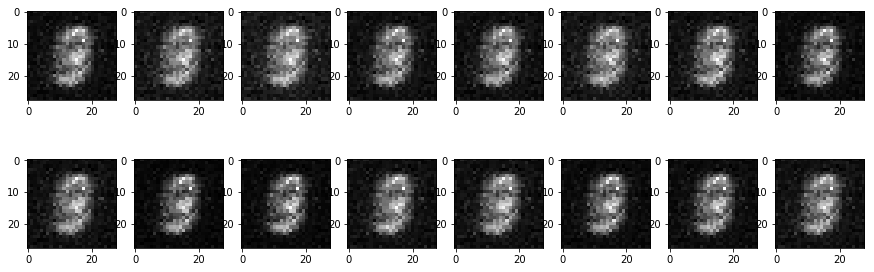

tensor(0.2381, device='cuda:0', grad_fn=<DivBackward0>)


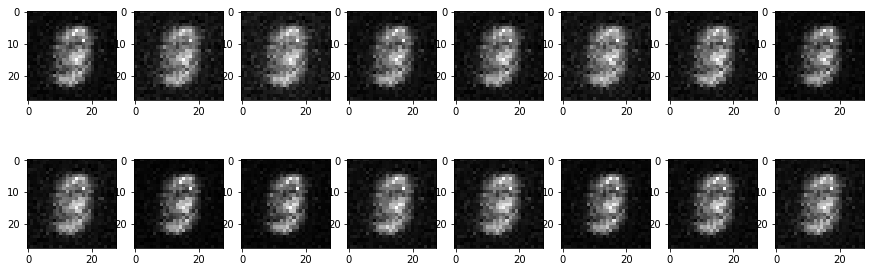

tensor(0.2657, device='cuda:0', grad_fn=<DivBackward0>)


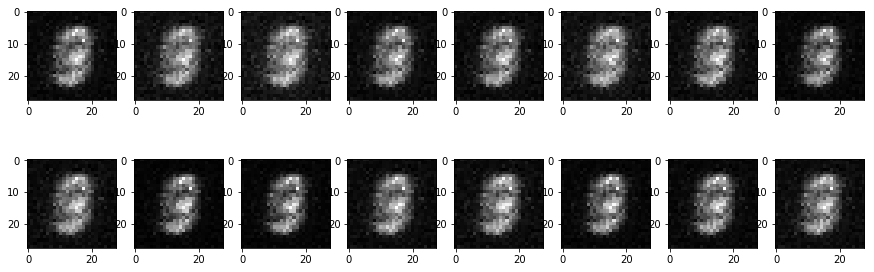

tensor(0.2382, device='cuda:0', grad_fn=<DivBackward0>)


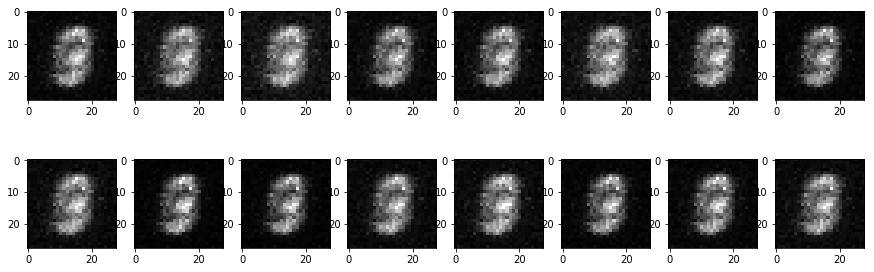

tensor(0.2489, device='cuda:0', grad_fn=<DivBackward0>)


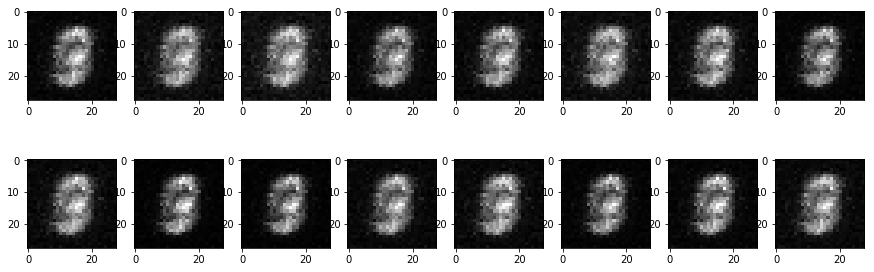

tensor(0.2454, device='cuda:0', grad_fn=<DivBackward0>)


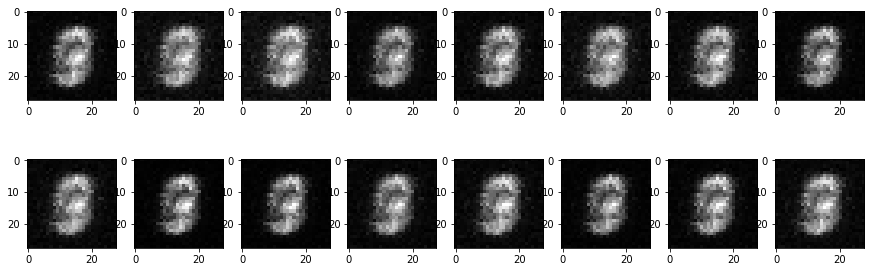

tensor(0.2369, device='cuda:0', grad_fn=<DivBackward0>)


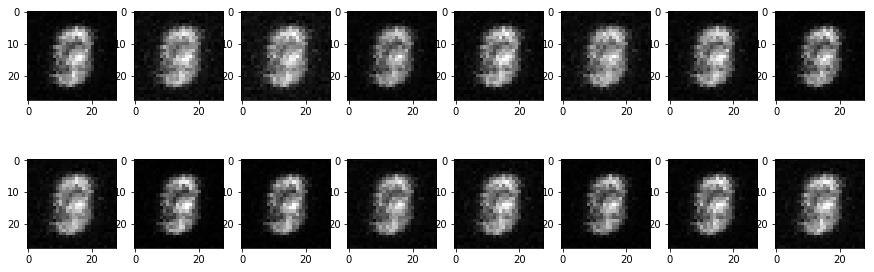

tensor(0.2257, device='cuda:0', grad_fn=<DivBackward0>)


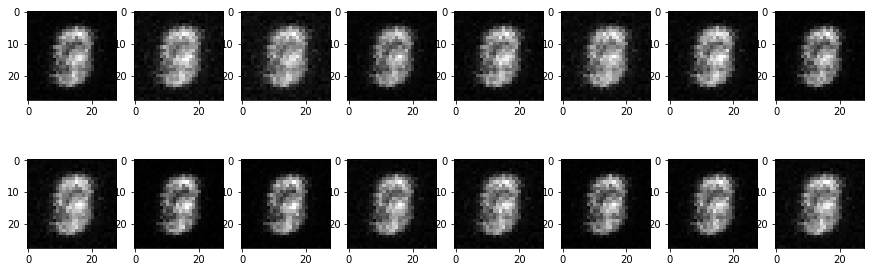

tensor(0.2513, device='cuda:0', grad_fn=<DivBackward0>)


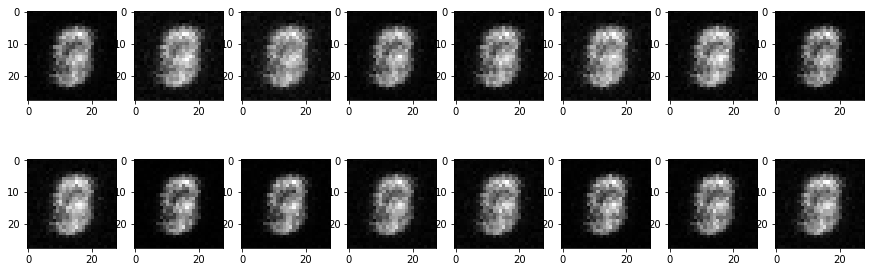

tensor(0.2417, device='cuda:0', grad_fn=<DivBackward0>)


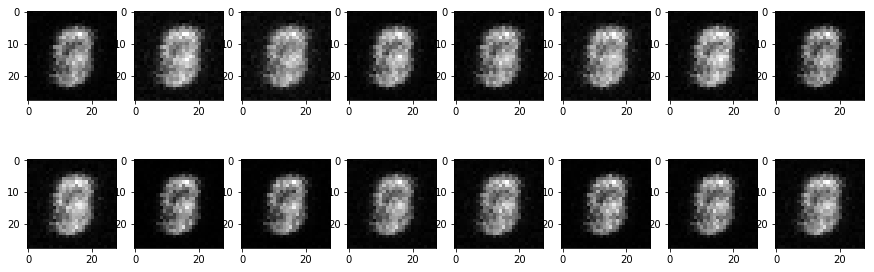

tensor(0.2478, device='cuda:0', grad_fn=<DivBackward0>)


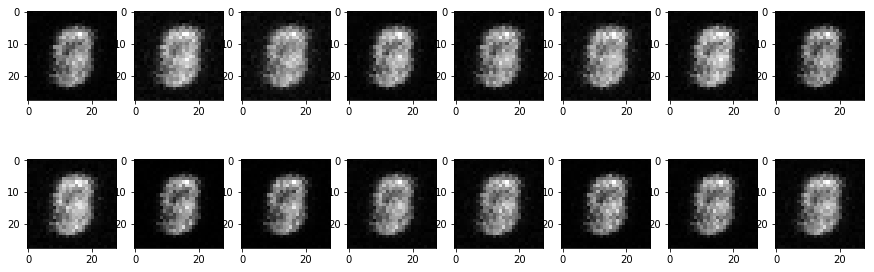

tensor(0.2528, device='cuda:0', grad_fn=<DivBackward0>)


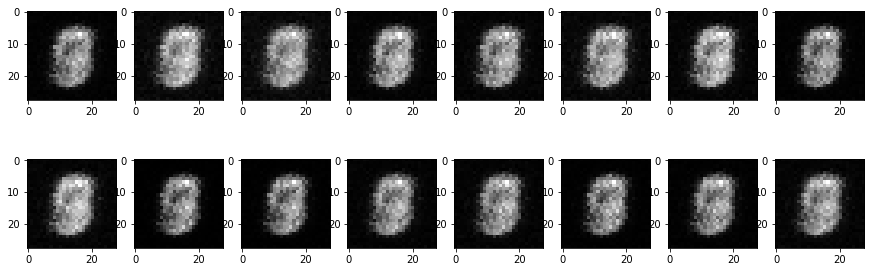

tensor(0.2292, device='cuda:0', grad_fn=<DivBackward0>)


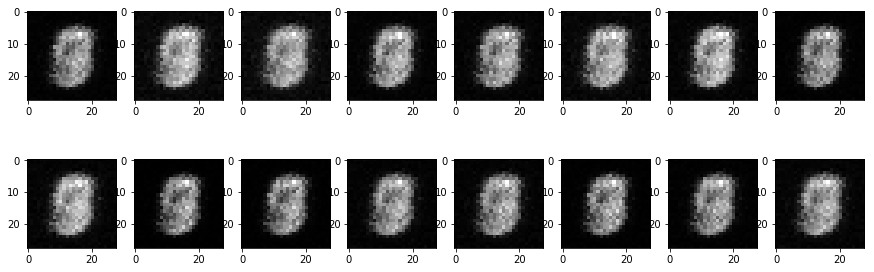

tensor(0.2047, device='cuda:0', grad_fn=<DivBackward0>)


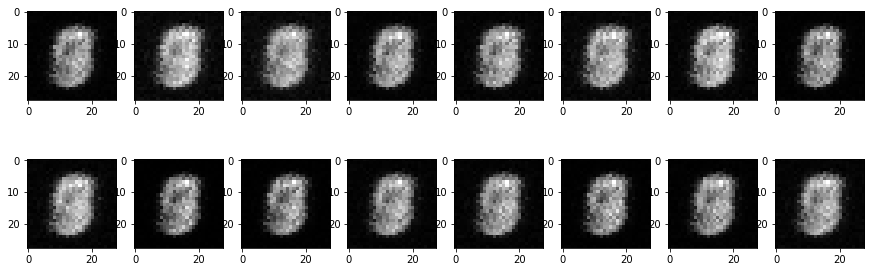

tensor(0.2313, device='cuda:0', grad_fn=<DivBackward0>)


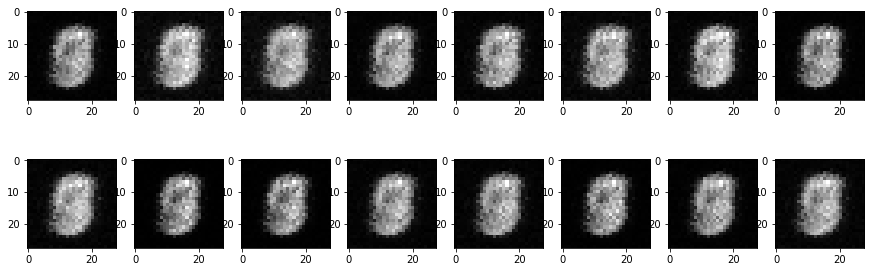

tensor(0.2369, device='cuda:0', grad_fn=<DivBackward0>)


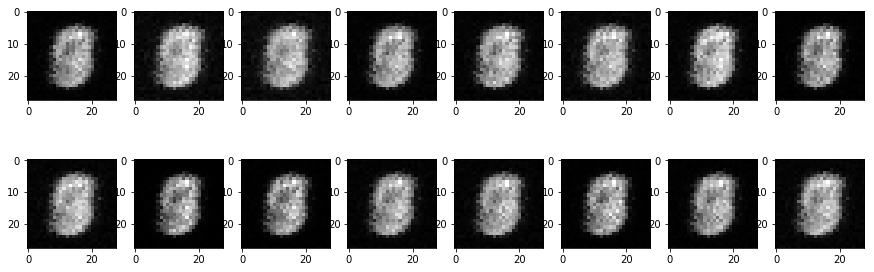

tensor(0.2345, device='cuda:0', grad_fn=<DivBackward0>)


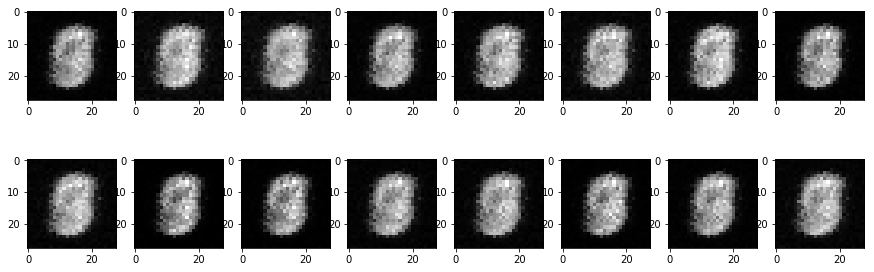

tensor(0.2245, device='cuda:0', grad_fn=<DivBackward0>)


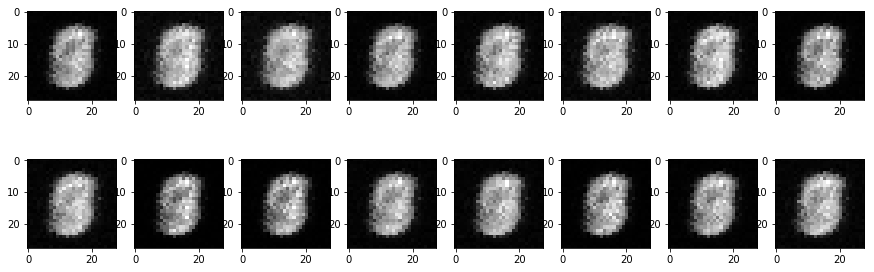

tensor(0.2339, device='cuda:0', grad_fn=<DivBackward0>)


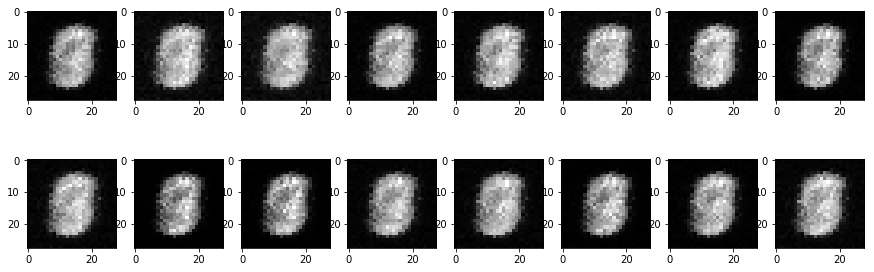

tensor(0.2220, device='cuda:0', grad_fn=<DivBackward0>)


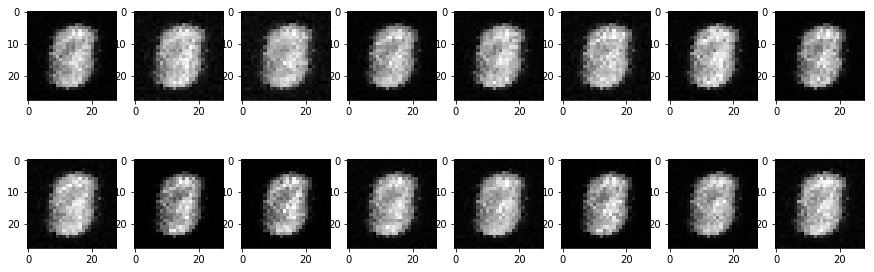

tensor(0.2295, device='cuda:0', grad_fn=<DivBackward0>)


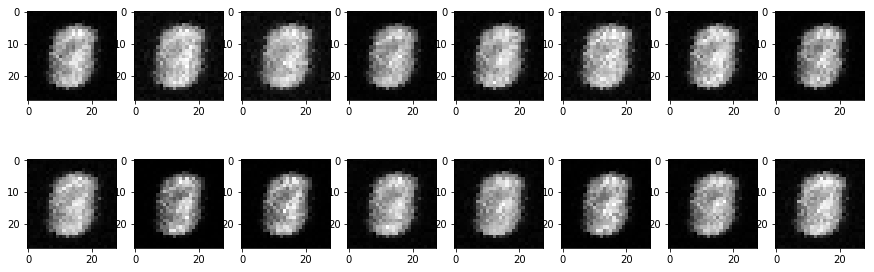

tensor(0.2338, device='cuda:0', grad_fn=<DivBackward0>)


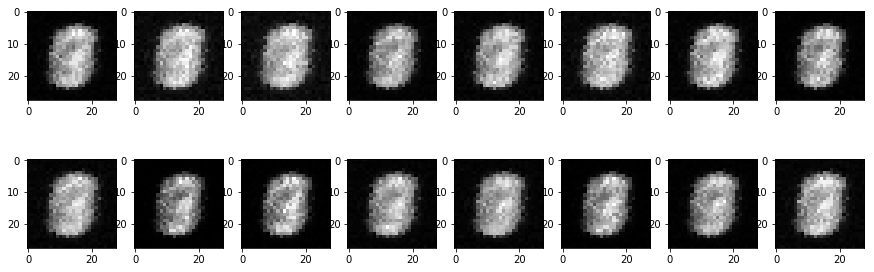

tensor(0.2214, device='cuda:0', grad_fn=<DivBackward0>)


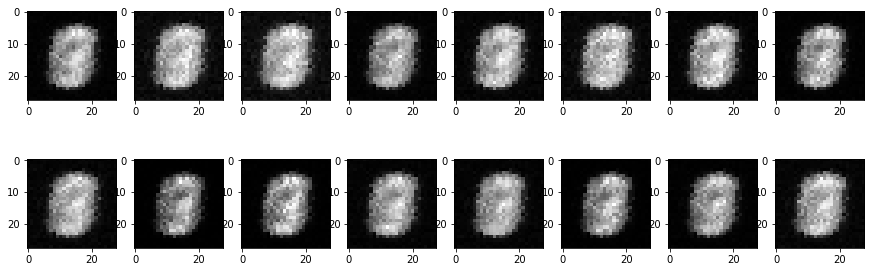

tensor(0.2155, device='cuda:0', grad_fn=<DivBackward0>)


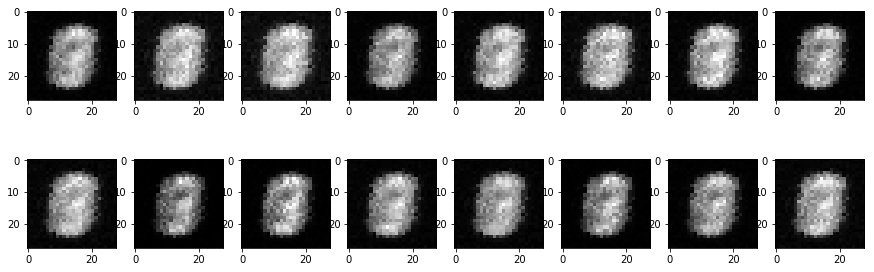

tensor(0.2213, device='cuda:0', grad_fn=<DivBackward0>)


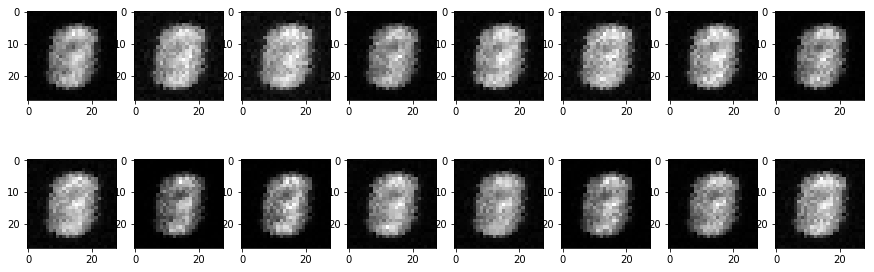

tensor(0.2356, device='cuda:0', grad_fn=<DivBackward0>)


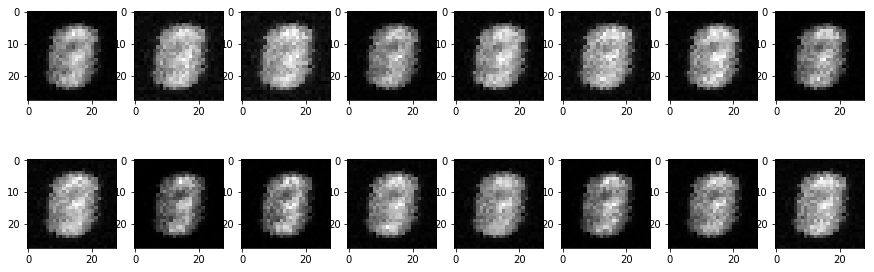

tensor(0.2336, device='cuda:0', grad_fn=<DivBackward0>)


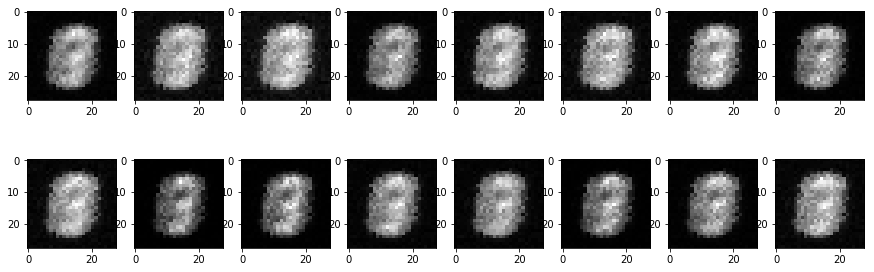

tensor(0.2195, device='cuda:0', grad_fn=<DivBackward0>)


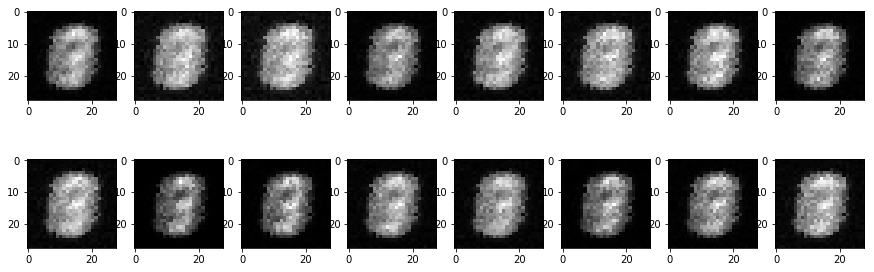

tensor(0.2206, device='cuda:0', grad_fn=<DivBackward0>)


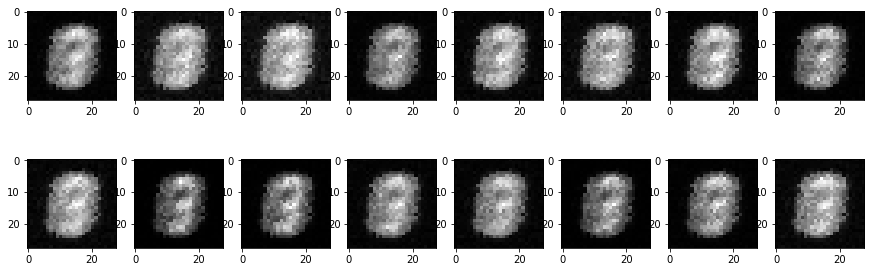

tensor(0.2055, device='cuda:0', grad_fn=<DivBackward0>)


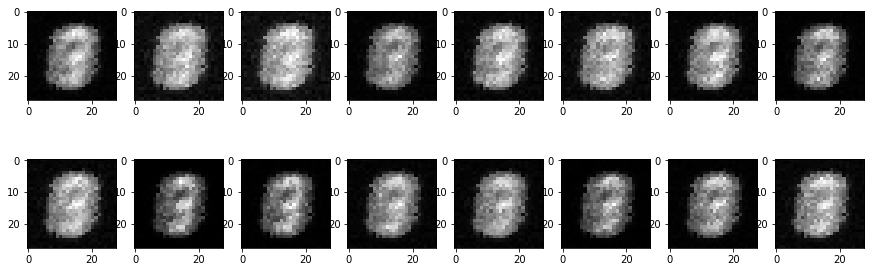

tensor(0.2242, device='cuda:0', grad_fn=<DivBackward0>)


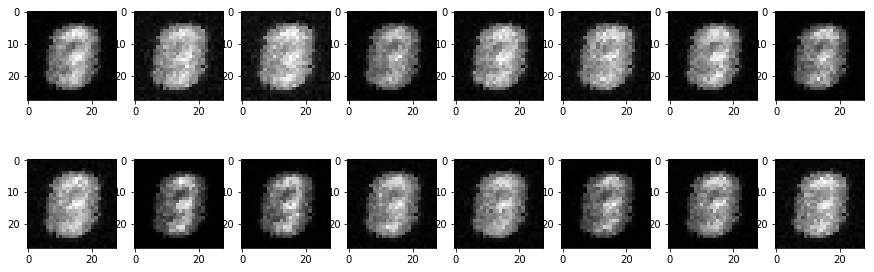

tensor(0.2348, device='cuda:0', grad_fn=<DivBackward0>)


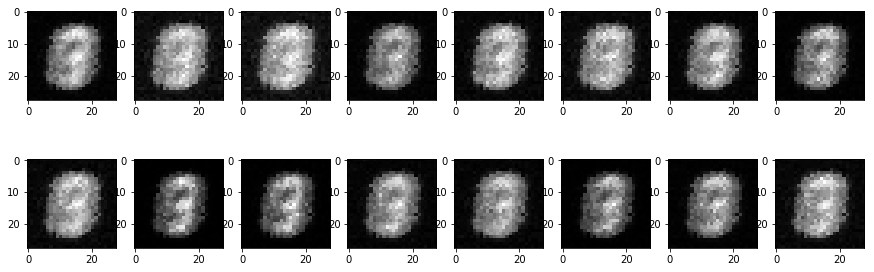

tensor(0.2005, device='cuda:0', grad_fn=<DivBackward0>)


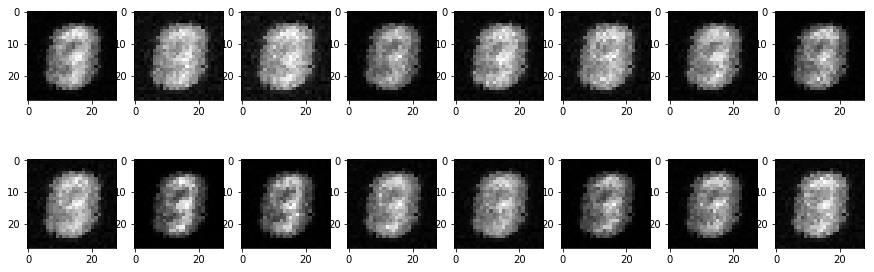

tensor(0.2111, device='cuda:0', grad_fn=<DivBackward0>)


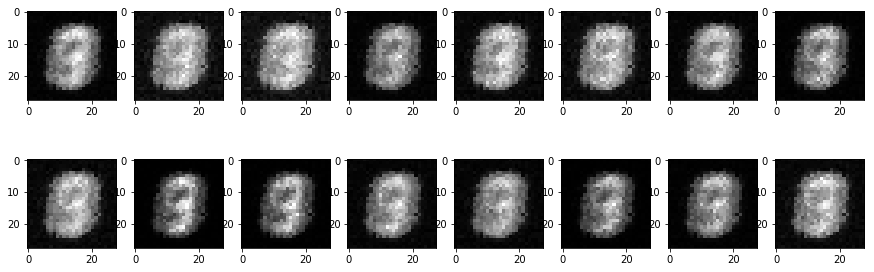

tensor(0.2081, device='cuda:0', grad_fn=<DivBackward0>)


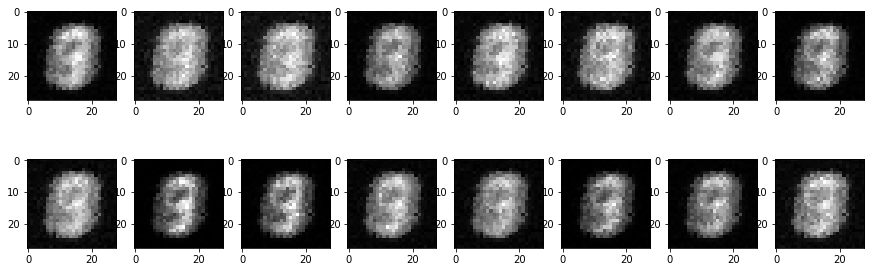

tensor(0.1961, device='cuda:0', grad_fn=<DivBackward0>)


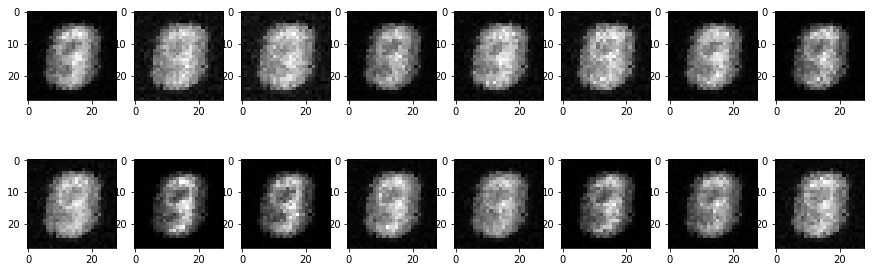

tensor(0.2039, device='cuda:0', grad_fn=<DivBackward0>)


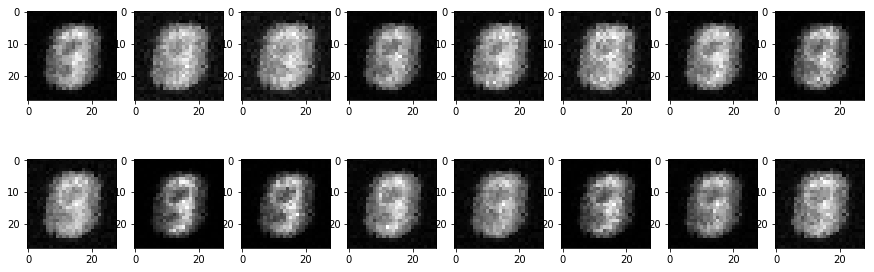

tensor(0.1972, device='cuda:0', grad_fn=<DivBackward0>)


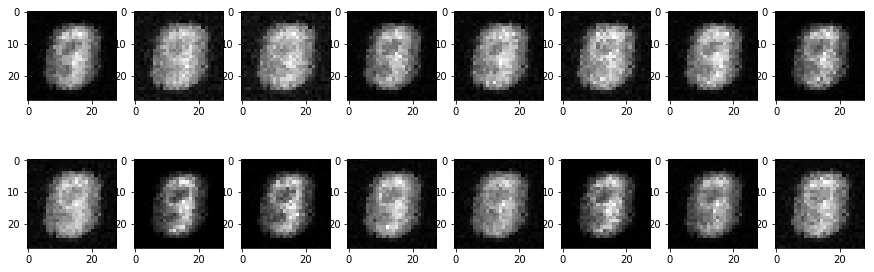

tensor(0.2002, device='cuda:0', grad_fn=<DivBackward0>)


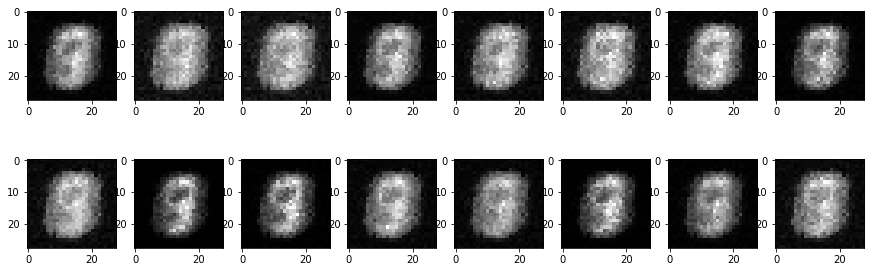

tensor(0.2007, device='cuda:0', grad_fn=<DivBackward0>)


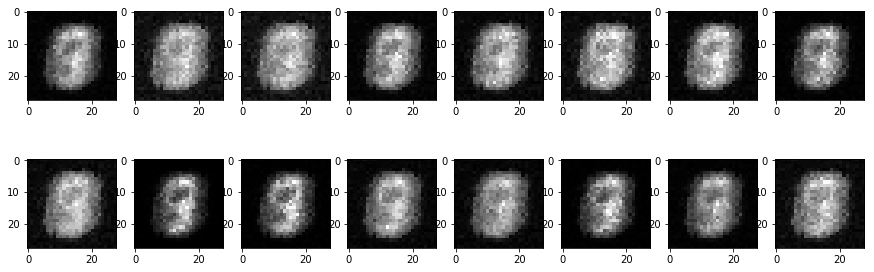

tensor(0.2024, device='cuda:0', grad_fn=<DivBackward0>)


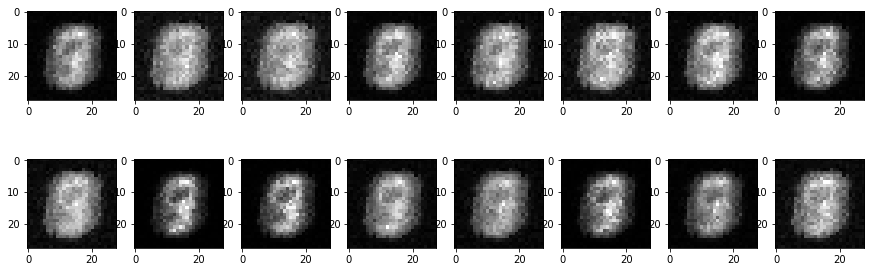

tensor(0.1927, device='cuda:0', grad_fn=<DivBackward0>)


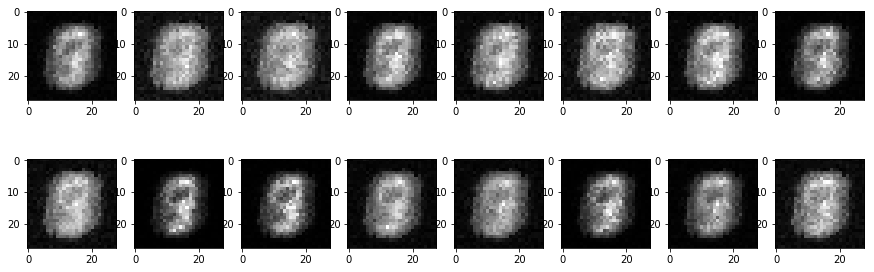

tensor(0.1998, device='cuda:0', grad_fn=<DivBackward0>)


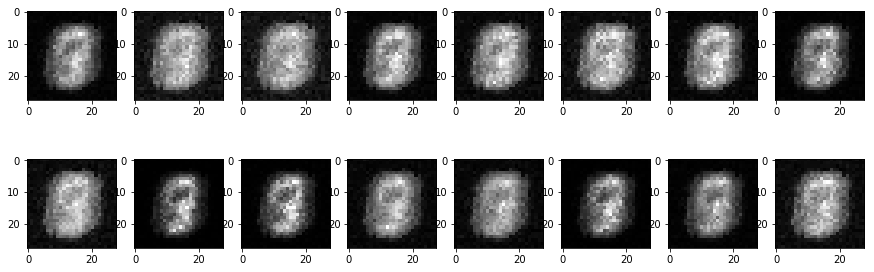

tensor(0.1963, device='cuda:0', grad_fn=<DivBackward0>)


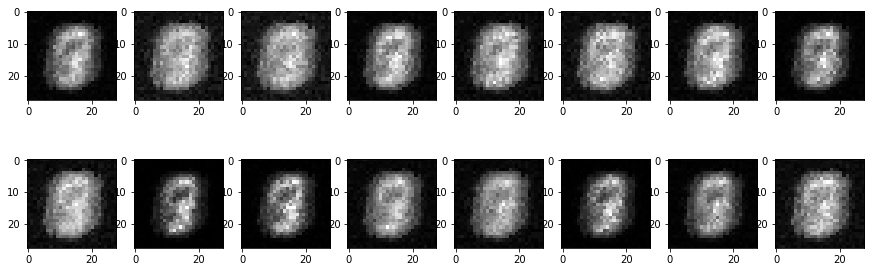

tensor(0.1935, device='cuda:0', grad_fn=<DivBackward0>)


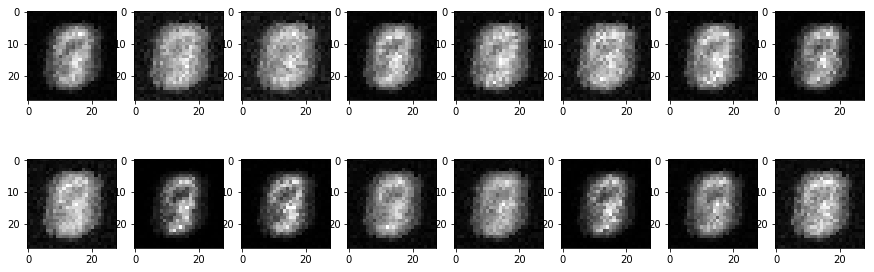

tensor(0.1944, device='cuda:0', grad_fn=<DivBackward0>)


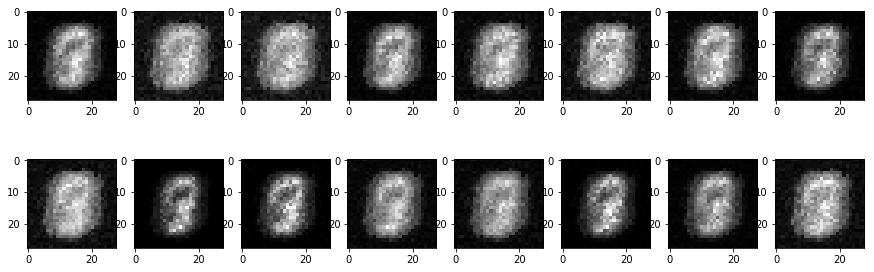

tensor(0.2175, device='cuda:0', grad_fn=<DivBackward0>)


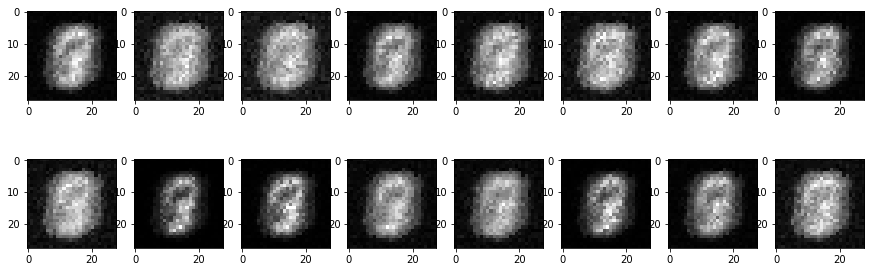

tensor(0.2029, device='cuda:0', grad_fn=<DivBackward0>)


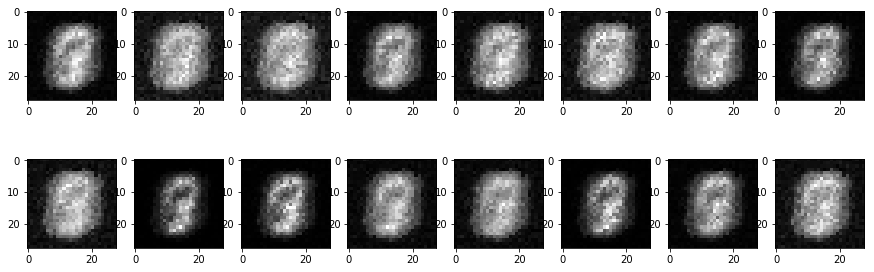

tensor(0.1893, device='cuda:0', grad_fn=<DivBackward0>)


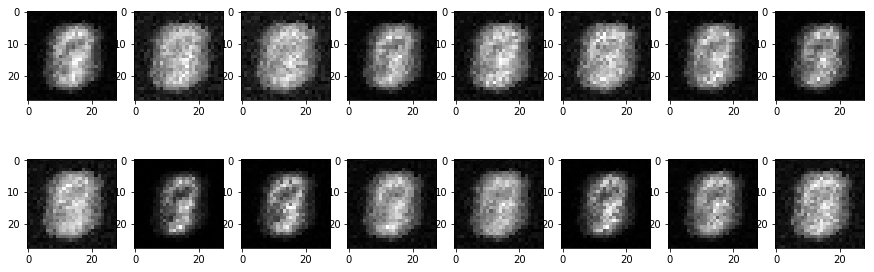

tensor(0.1743, device='cuda:0', grad_fn=<DivBackward0>)


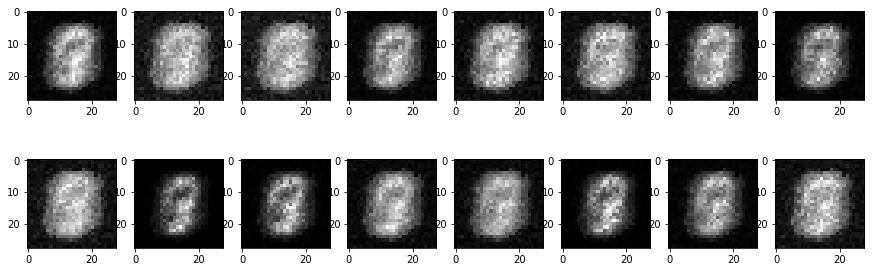

tensor(0.1843, device='cuda:0', grad_fn=<DivBackward0>)


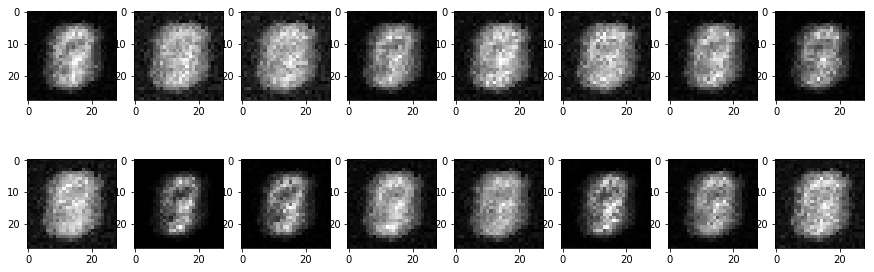

tensor(0.1823, device='cuda:0', grad_fn=<DivBackward0>)


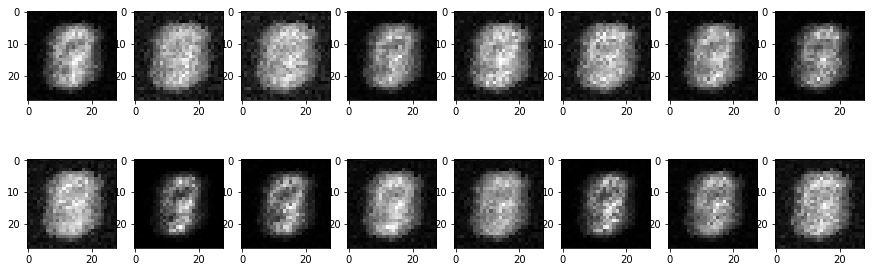

tensor(0.1852, device='cuda:0', grad_fn=<DivBackward0>)


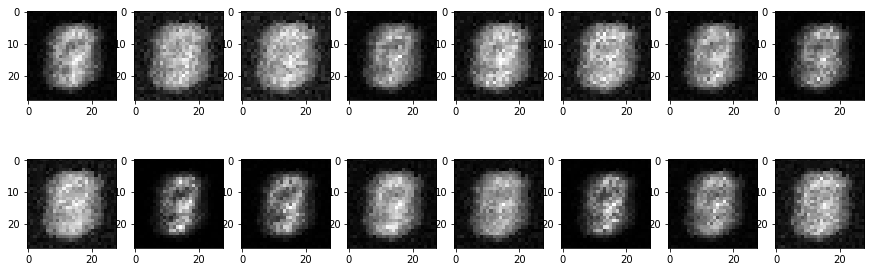

tensor(0.1802, device='cuda:0', grad_fn=<DivBackward0>)


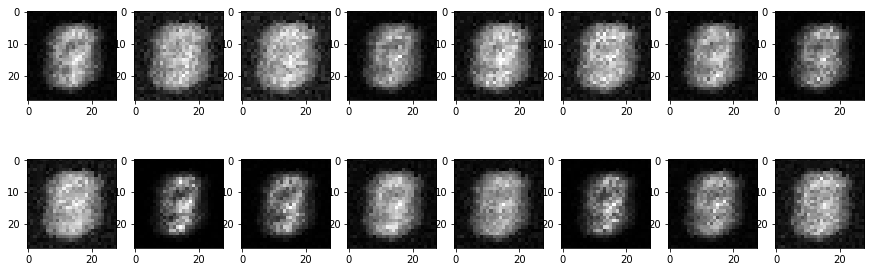

tensor(0.1729, device='cuda:0', grad_fn=<DivBackward0>)


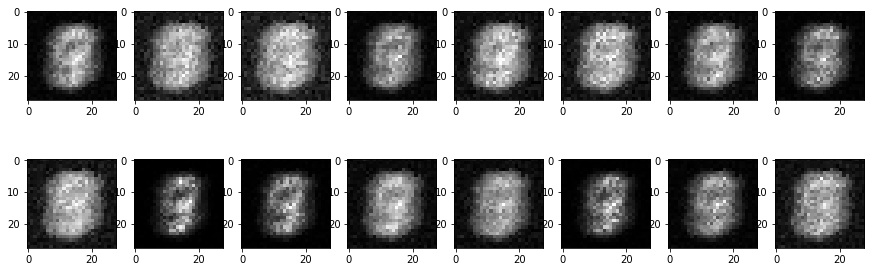

tensor(0.1843, device='cuda:0', grad_fn=<DivBackward0>)


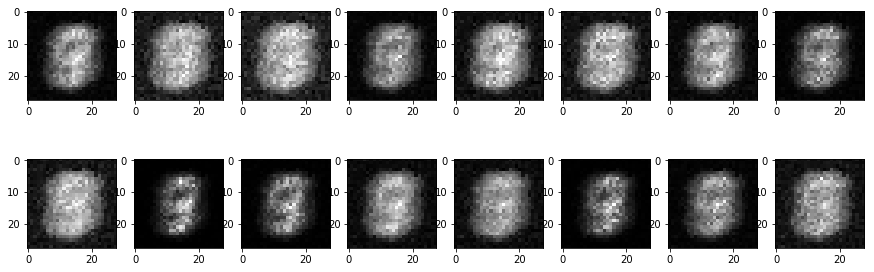

tensor(0.1884, device='cuda:0', grad_fn=<DivBackward0>)


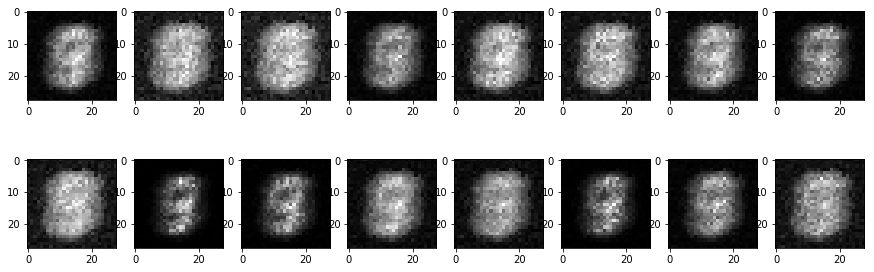

tensor(0.1710, device='cuda:0', grad_fn=<DivBackward0>)


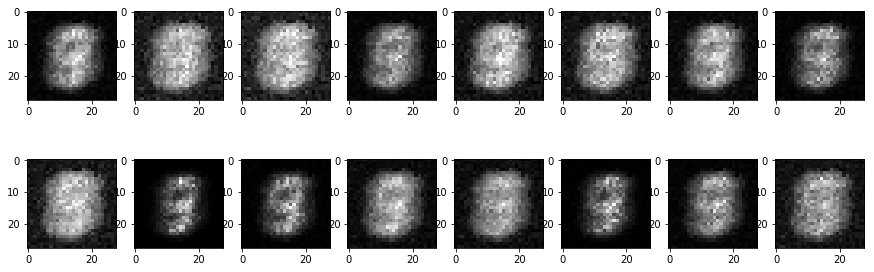

tensor(0.1677, device='cuda:0', grad_fn=<DivBackward0>)


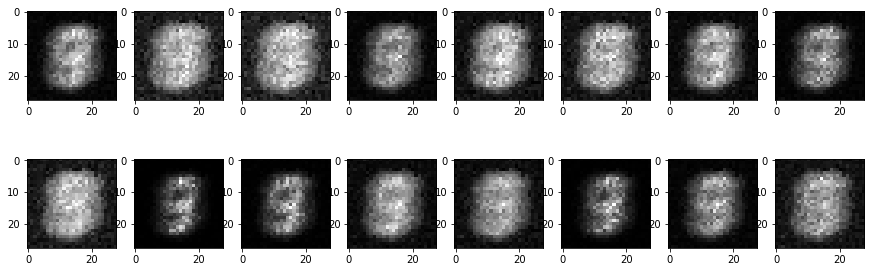

tensor(0.1698, device='cuda:0', grad_fn=<DivBackward0>)


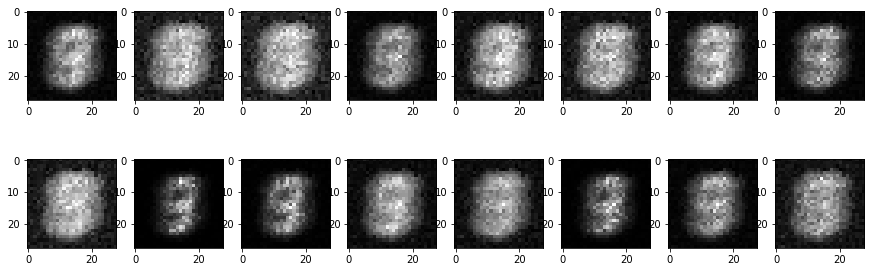

tensor(0.1701, device='cuda:0', grad_fn=<DivBackward0>)


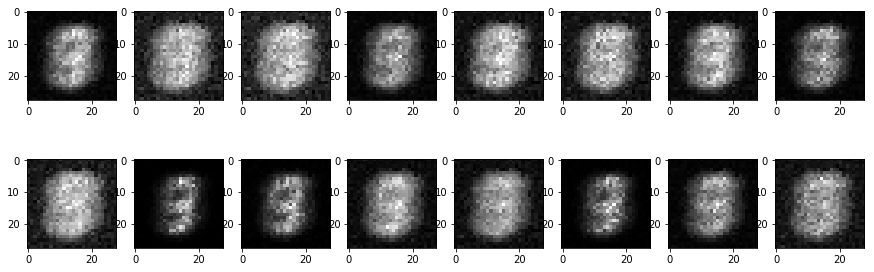

tensor(0.1757, device='cuda:0', grad_fn=<DivBackward0>)


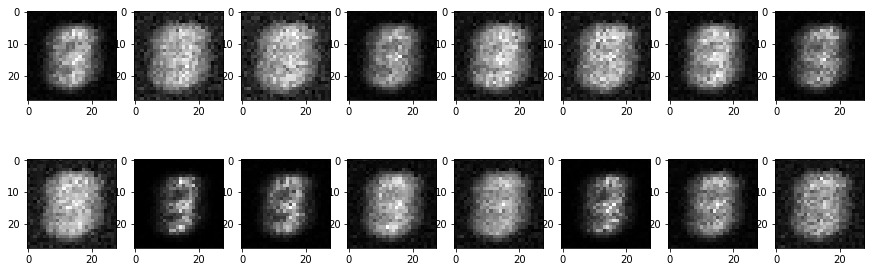

tensor(0.1732, device='cuda:0', grad_fn=<DivBackward0>)


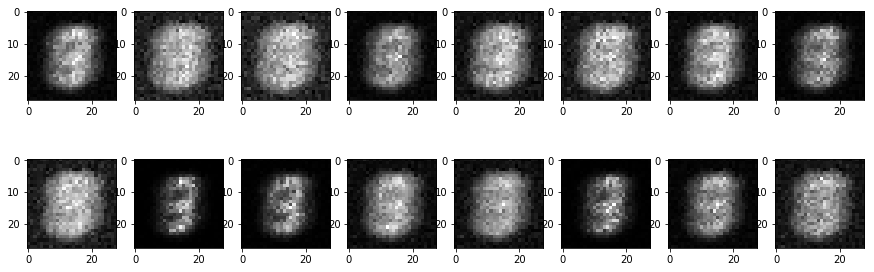

tensor(0.1641, device='cuda:0', grad_fn=<DivBackward0>)


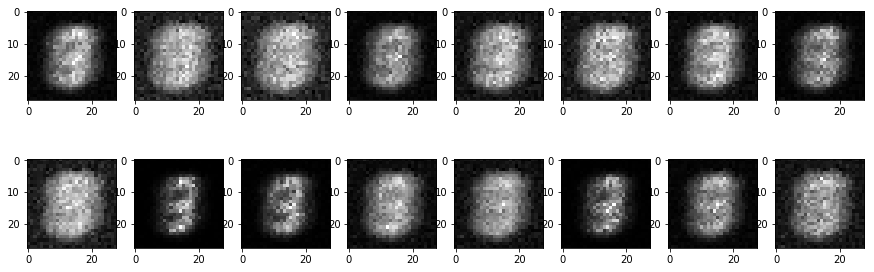

tensor(0.1780, device='cuda:0', grad_fn=<DivBackward0>)


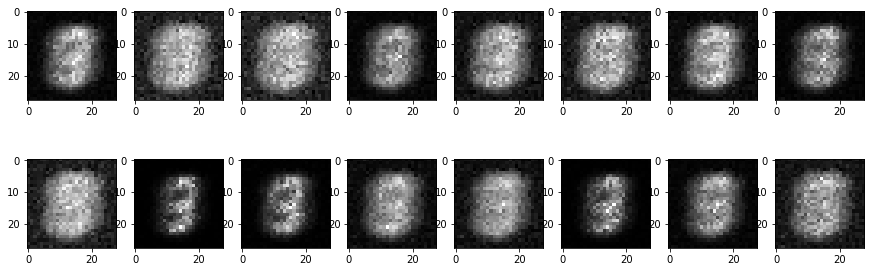

tensor(0.1665, device='cuda:0', grad_fn=<DivBackward0>)


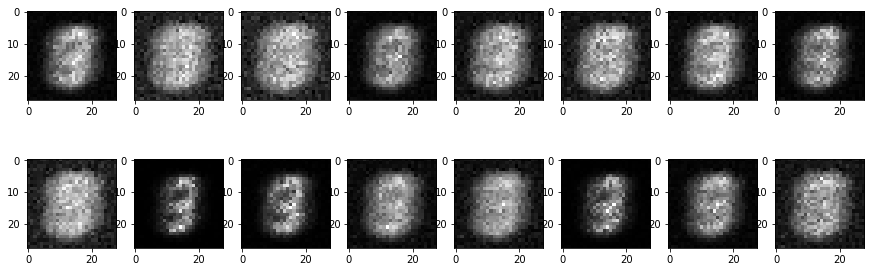

tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>)


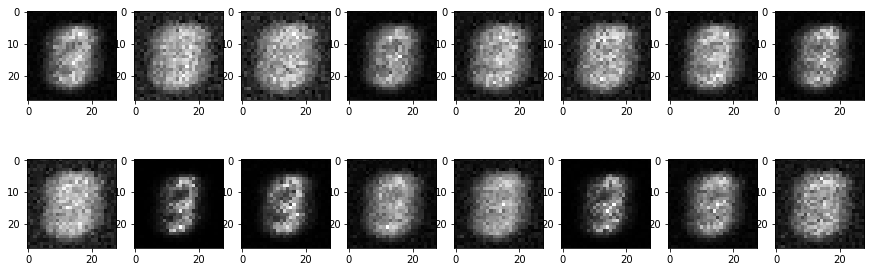

tensor(0.1594, device='cuda:0', grad_fn=<DivBackward0>)


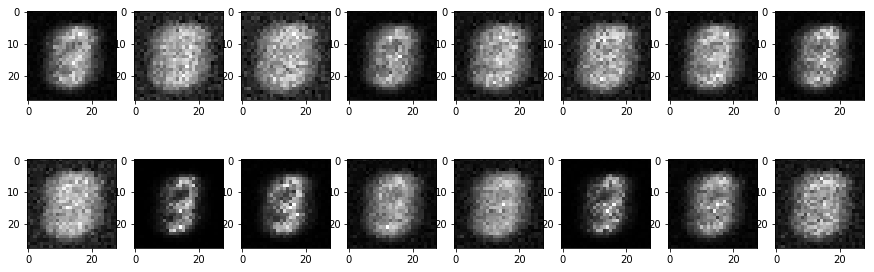

tensor(0.1631, device='cuda:0', grad_fn=<DivBackward0>)


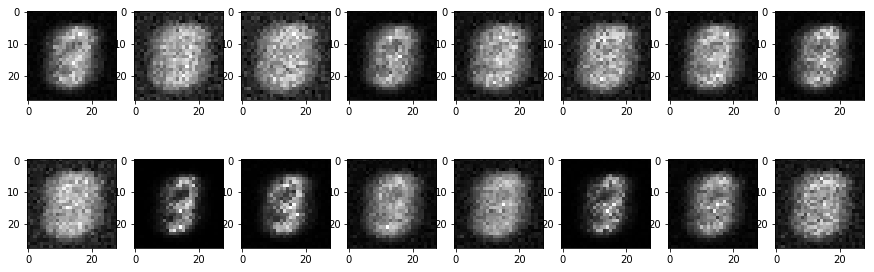

tensor(0.1740, device='cuda:0', grad_fn=<DivBackward0>)


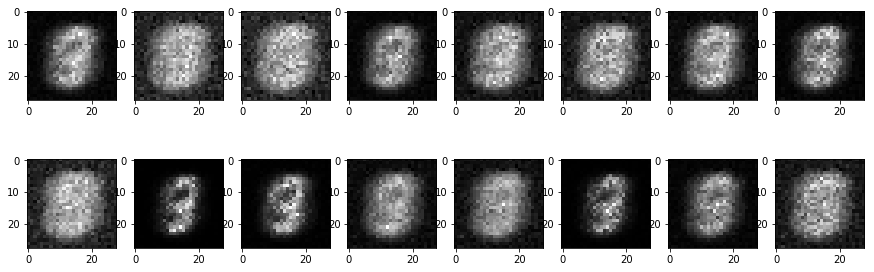

tensor(0.1470, device='cuda:0', grad_fn=<DivBackward0>)


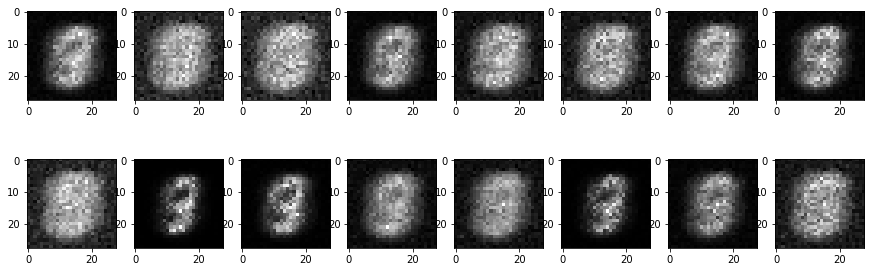

tensor(0.1605, device='cuda:0', grad_fn=<DivBackward0>)


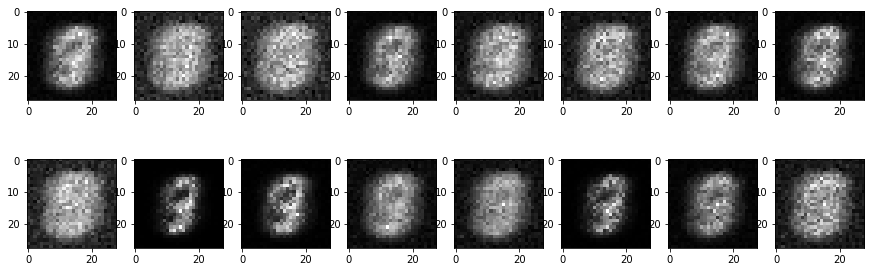

tensor(0.1507, device='cuda:0', grad_fn=<DivBackward0>)


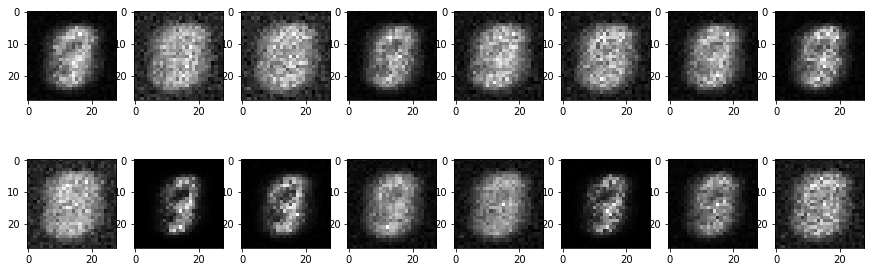

tensor(0.1571, device='cuda:0', grad_fn=<DivBackward0>)


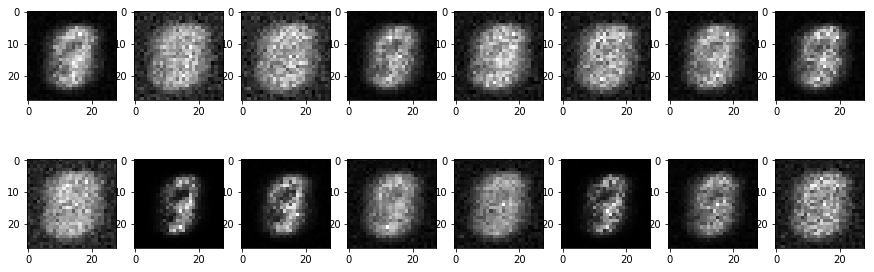

tensor(0.1580, device='cuda:0', grad_fn=<DivBackward0>)


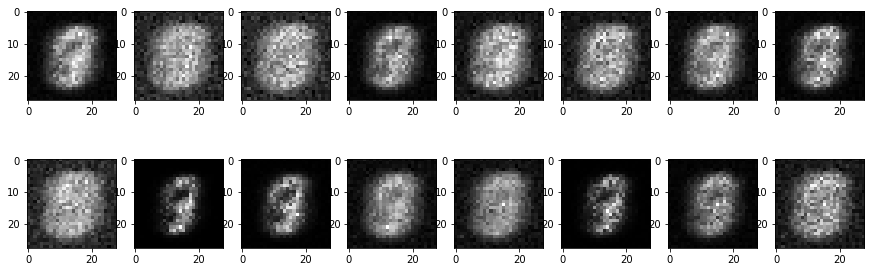

tensor(0.1486, device='cuda:0', grad_fn=<DivBackward0>)


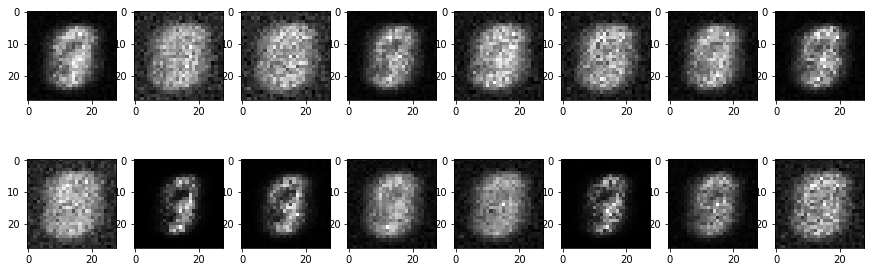

tensor(0.1399, device='cuda:0', grad_fn=<DivBackward0>)


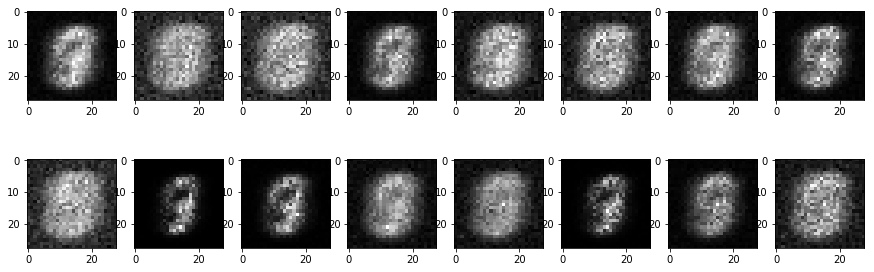

tensor(0.1454, device='cuda:0', grad_fn=<DivBackward0>)


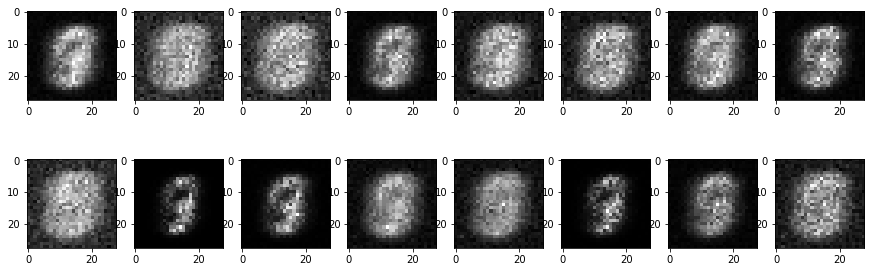

tensor(0.1503, device='cuda:0', grad_fn=<DivBackward0>)


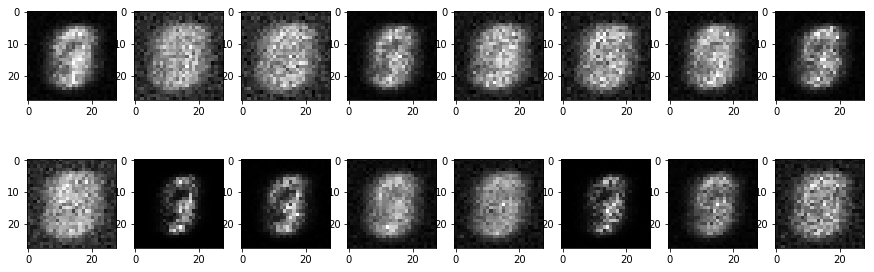

tensor(0.1416, device='cuda:0', grad_fn=<DivBackward0>)


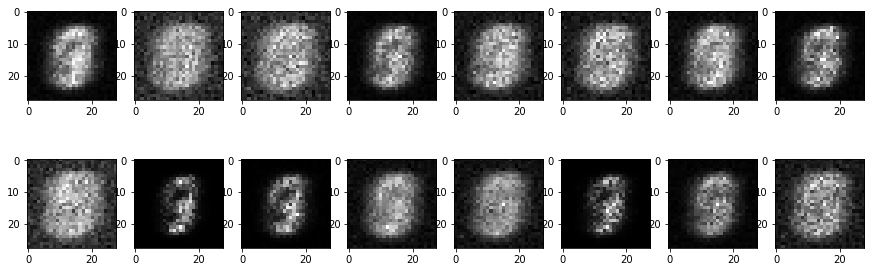

tensor(0.1411, device='cuda:0', grad_fn=<DivBackward0>)


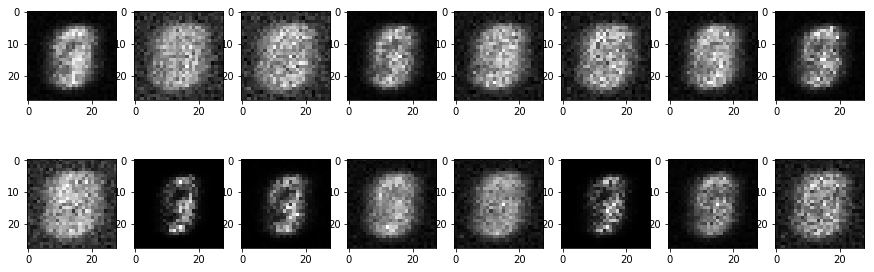

tensor(0.1505, device='cuda:0', grad_fn=<DivBackward0>)


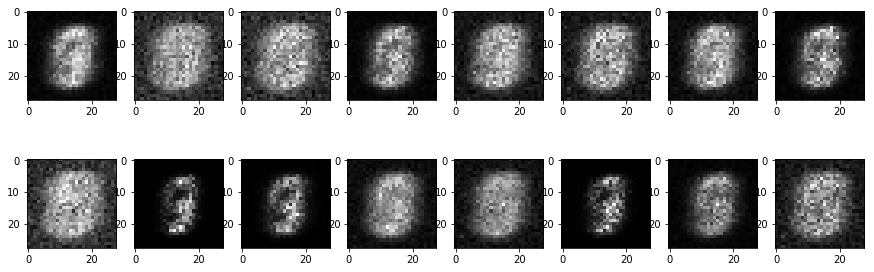

tensor(0.1272, device='cuda:0', grad_fn=<DivBackward0>)


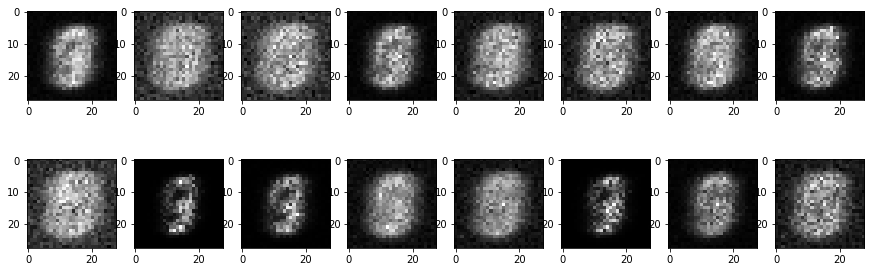

tensor(0.1279, device='cuda:0', grad_fn=<DivBackward0>)


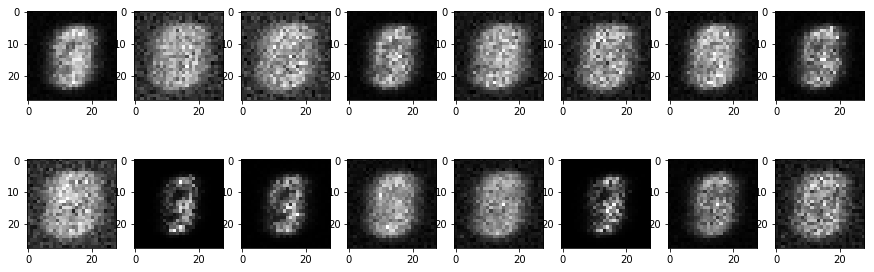

tensor(0.1370, device='cuda:0', grad_fn=<DivBackward0>)


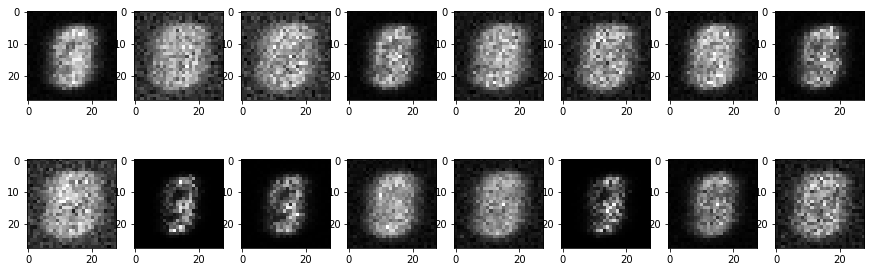

tensor(0.1374, device='cuda:0', grad_fn=<DivBackward0>)


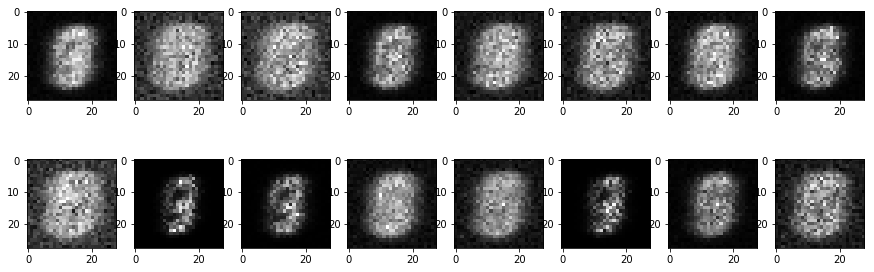

tensor(0.1234, device='cuda:0', grad_fn=<DivBackward0>)


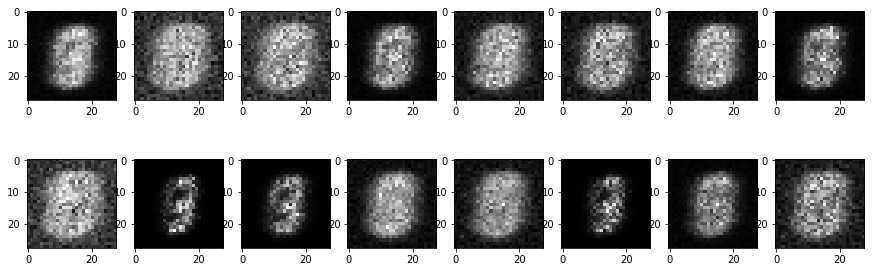

tensor(0.1313, device='cuda:0', grad_fn=<DivBackward0>)


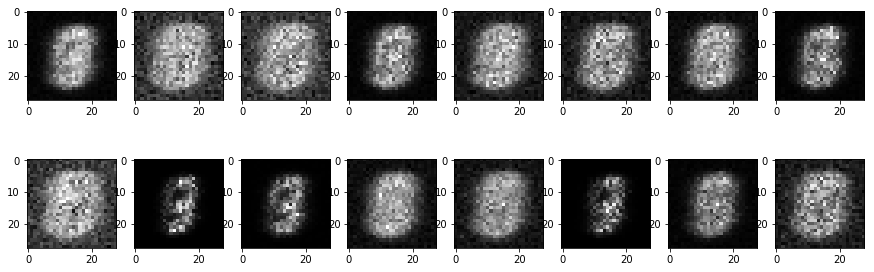

tensor(0.1348, device='cuda:0', grad_fn=<DivBackward0>)


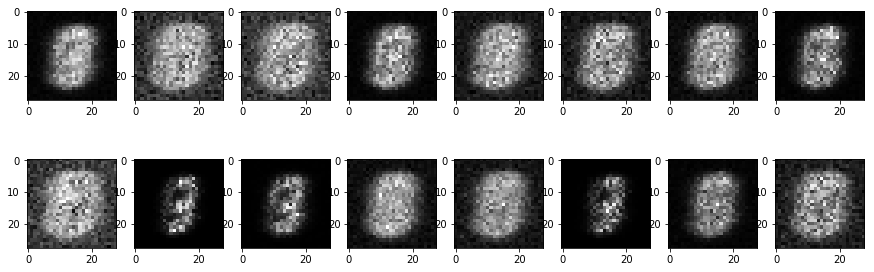

tensor(0.1258, device='cuda:0', grad_fn=<DivBackward0>)


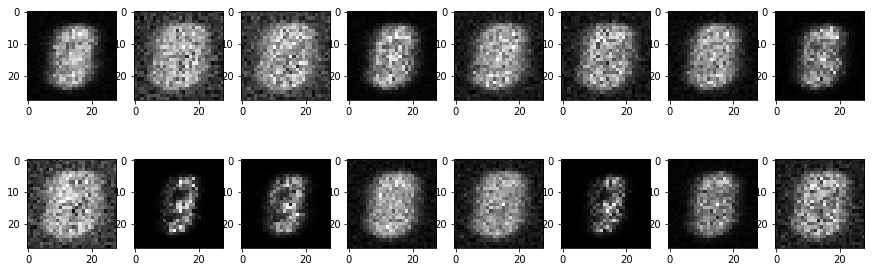

tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>)


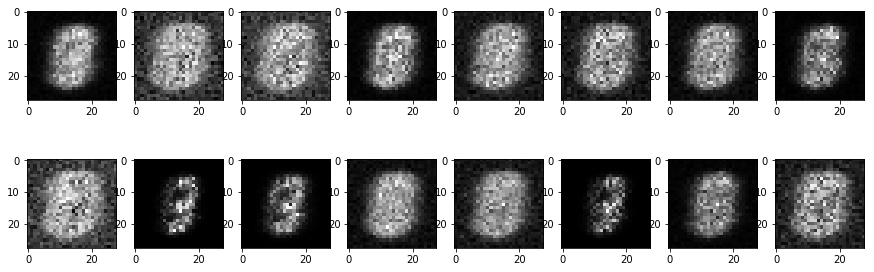

tensor(0.1173, device='cuda:0', grad_fn=<DivBackward0>)


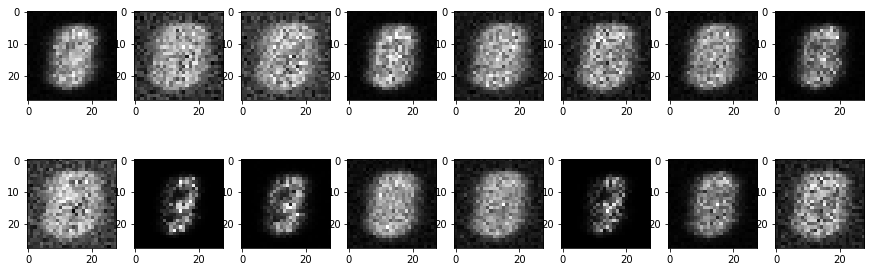

tensor(0.1140, device='cuda:0', grad_fn=<DivBackward0>)


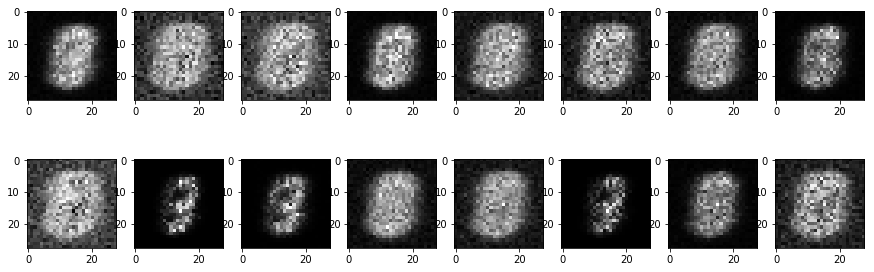

tensor(0.1255, device='cuda:0', grad_fn=<DivBackward0>)


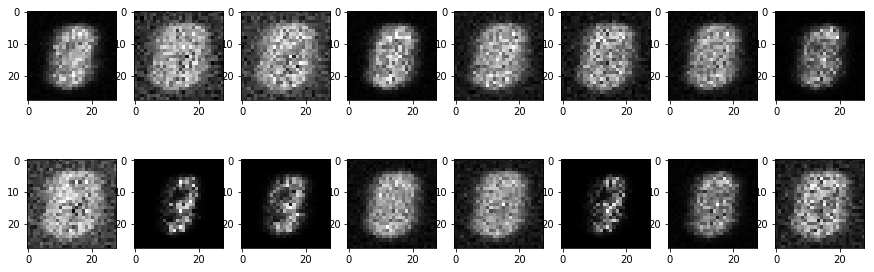

tensor(0.1137, device='cuda:0', grad_fn=<DivBackward0>)


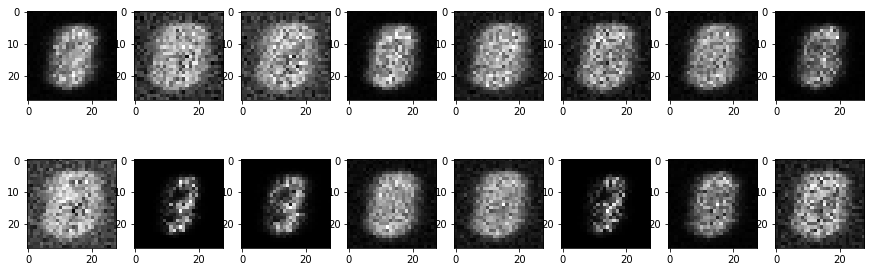

tensor(0.1218, device='cuda:0', grad_fn=<DivBackward0>)


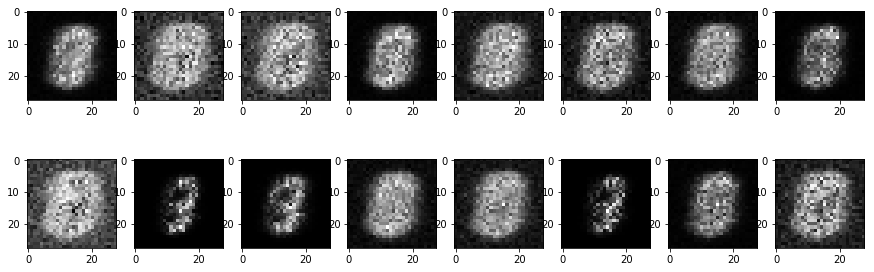

tensor(0.1085, device='cuda:0', grad_fn=<DivBackward0>)


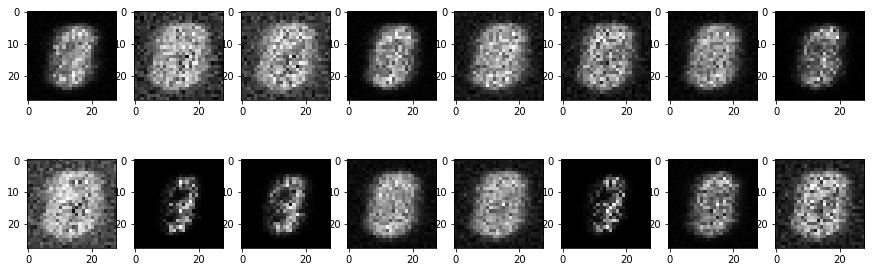

tensor(0.1159, device='cuda:0', grad_fn=<DivBackward0>)


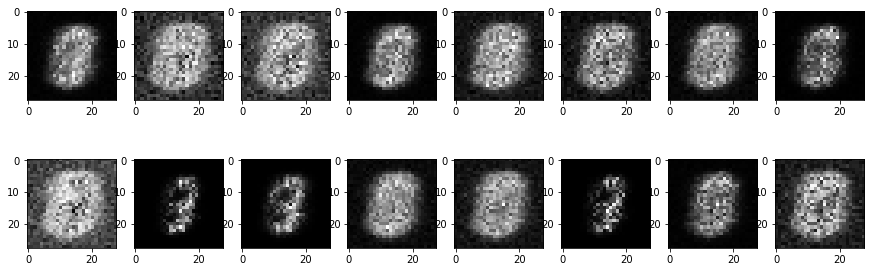

tensor(0.1056, device='cuda:0', grad_fn=<DivBackward0>)


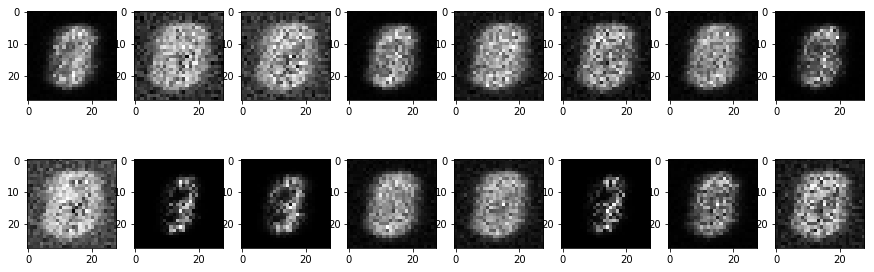

tensor(0.1062, device='cuda:0', grad_fn=<DivBackward0>)


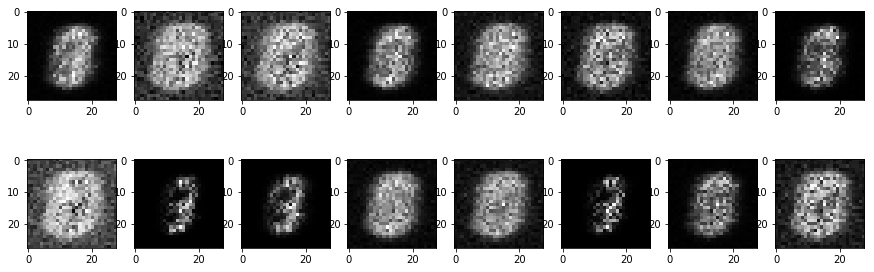

tensor(0.1001, device='cuda:0', grad_fn=<DivBackward0>)


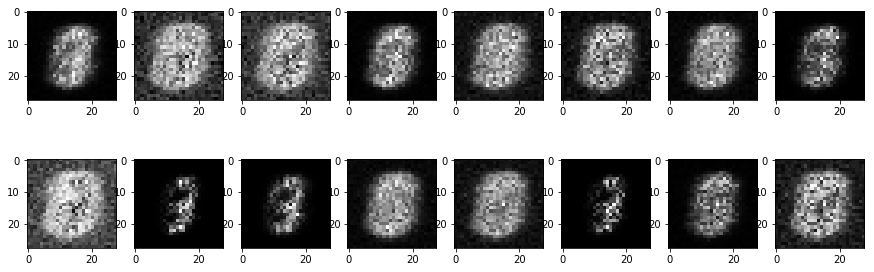

tensor(0.1098, device='cuda:0', grad_fn=<DivBackward0>)


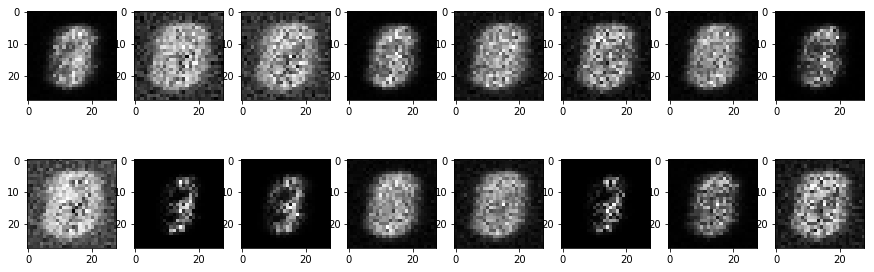

tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>)


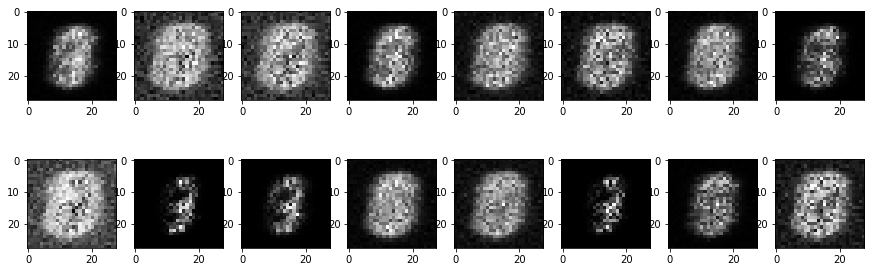

tensor(0.1014, device='cuda:0', grad_fn=<DivBackward0>)


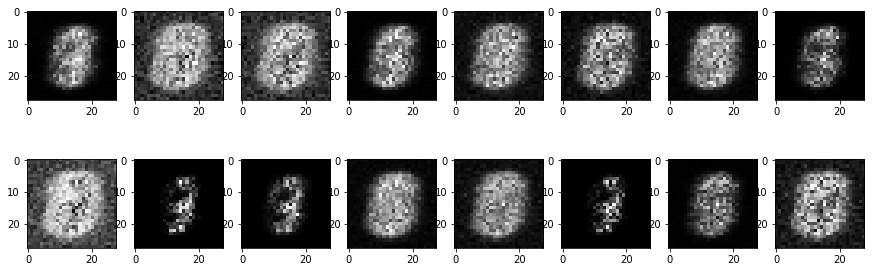

tensor(0.1154, device='cuda:0', grad_fn=<DivBackward0>)


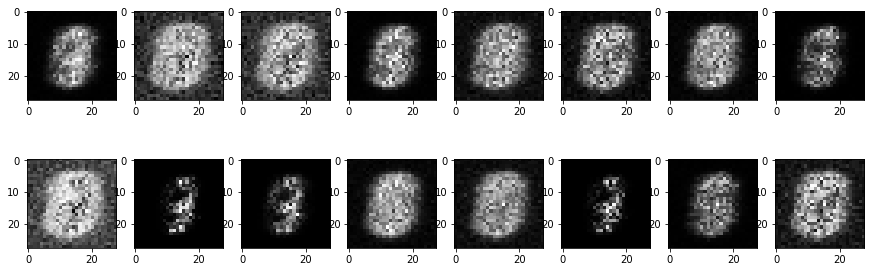

tensor(0.1008, device='cuda:0', grad_fn=<DivBackward0>)


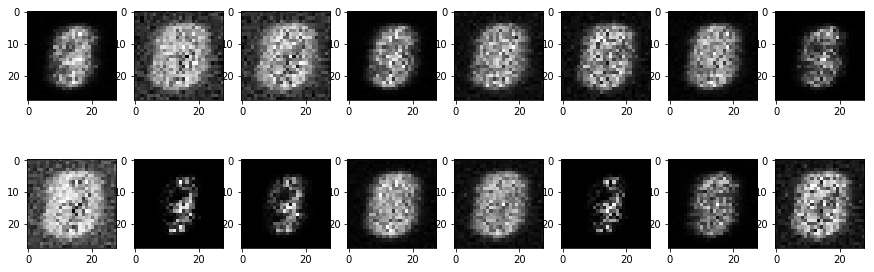

tensor(0.1095, device='cuda:0', grad_fn=<DivBackward0>)


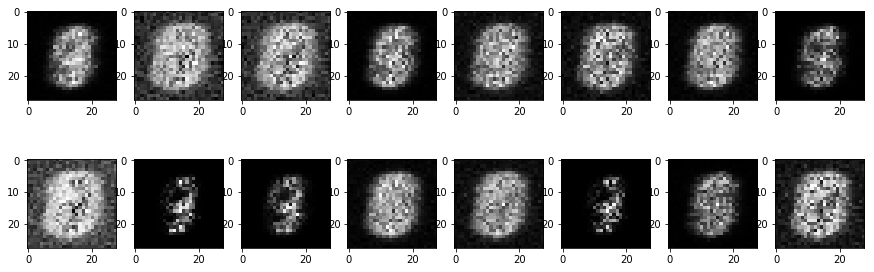

tensor(0.0967, device='cuda:0', grad_fn=<DivBackward0>)


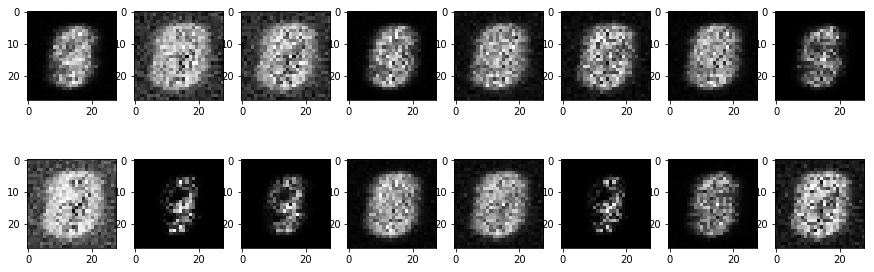

tensor(0.0920, device='cuda:0', grad_fn=<DivBackward0>)


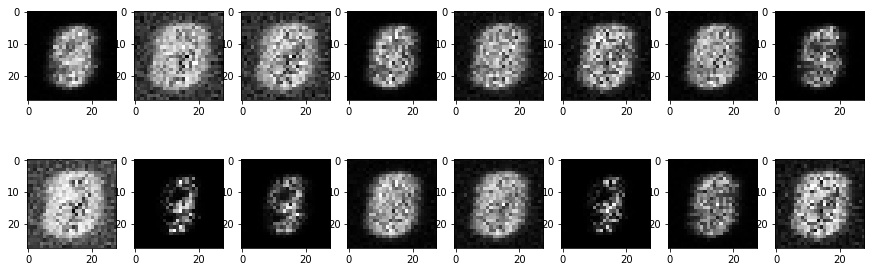

tensor(0.1036, device='cuda:0', grad_fn=<DivBackward0>)


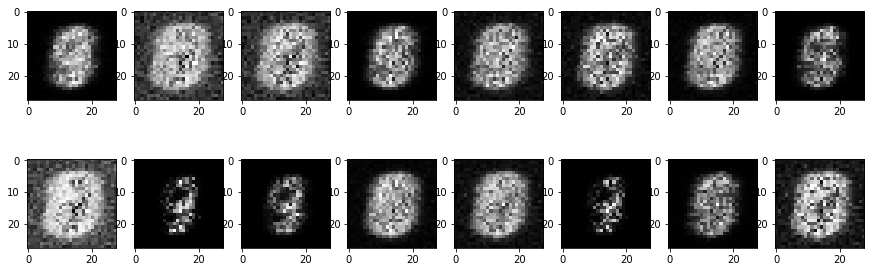

tensor(0.1007, device='cuda:0', grad_fn=<DivBackward0>)


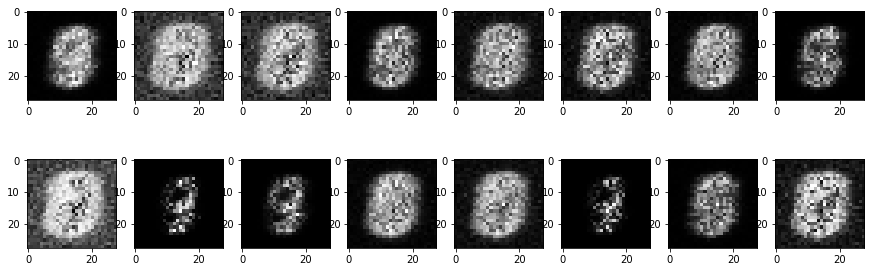

tensor(0.0930, device='cuda:0', grad_fn=<DivBackward0>)


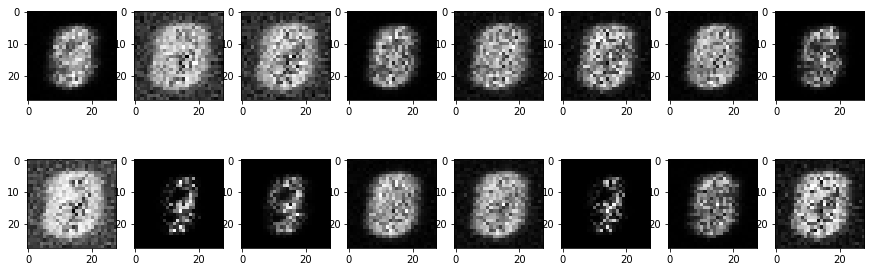

tensor(0.0952, device='cuda:0', grad_fn=<DivBackward0>)


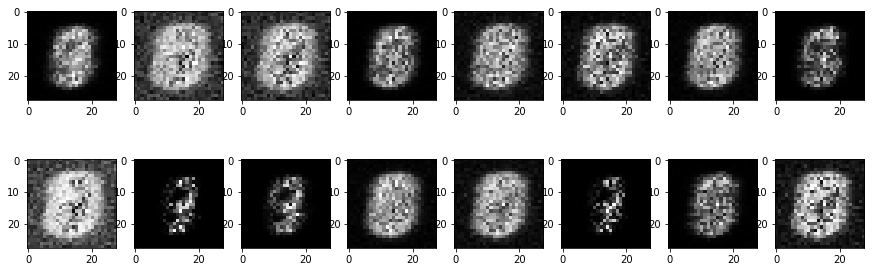

tensor(0.0778, device='cuda:0', grad_fn=<DivBackward0>)


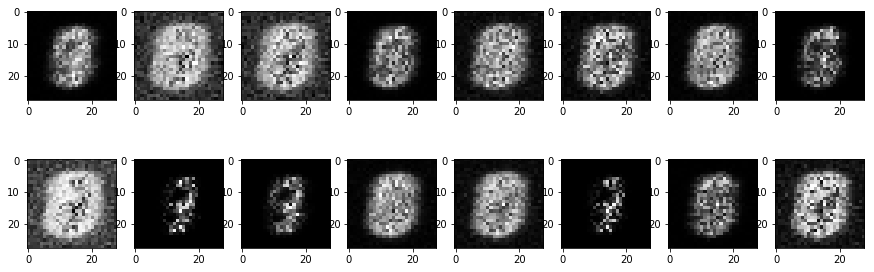

tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)


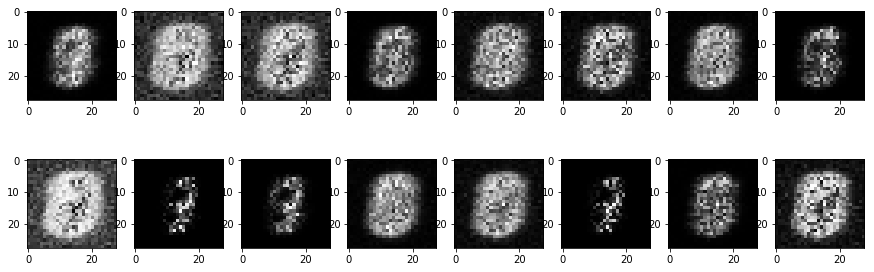

tensor(0.0923, device='cuda:0', grad_fn=<DivBackward0>)


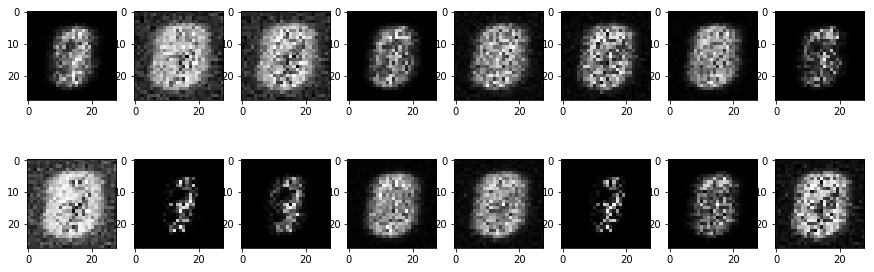

tensor(0.0860, device='cuda:0', grad_fn=<DivBackward0>)


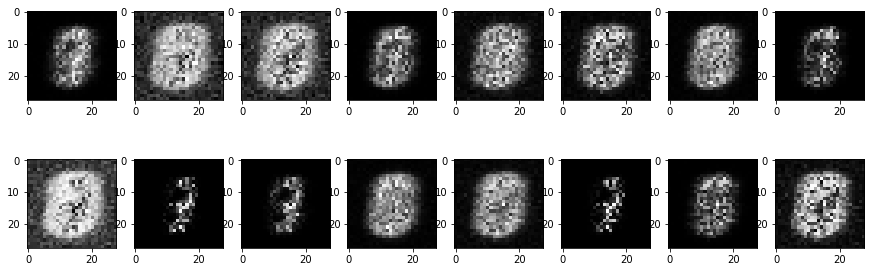

tensor(0.0917, device='cuda:0', grad_fn=<DivBackward0>)


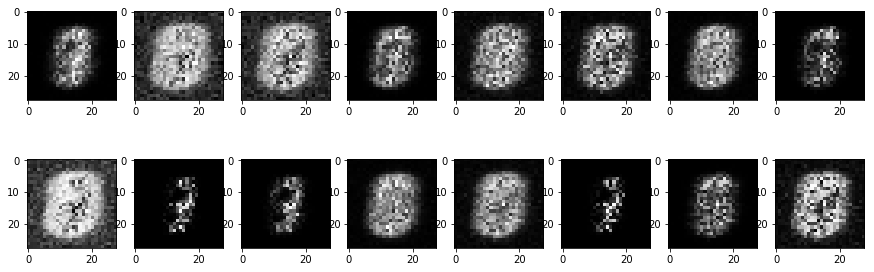

tensor(0.0916, device='cuda:0', grad_fn=<DivBackward0>)


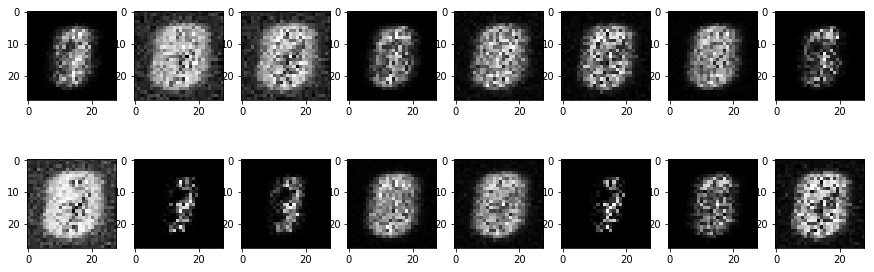

tensor(0.0858, device='cuda:0', grad_fn=<DivBackward0>)


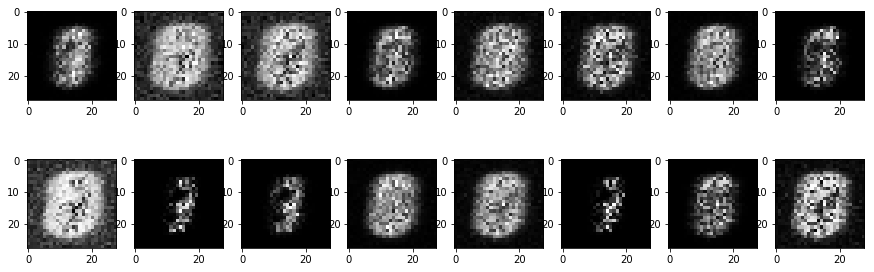

tensor(0.0861, device='cuda:0', grad_fn=<DivBackward0>)


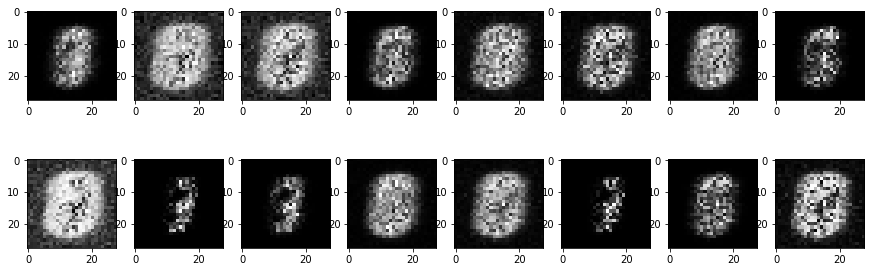

tensor(0.0843, device='cuda:0', grad_fn=<DivBackward0>)


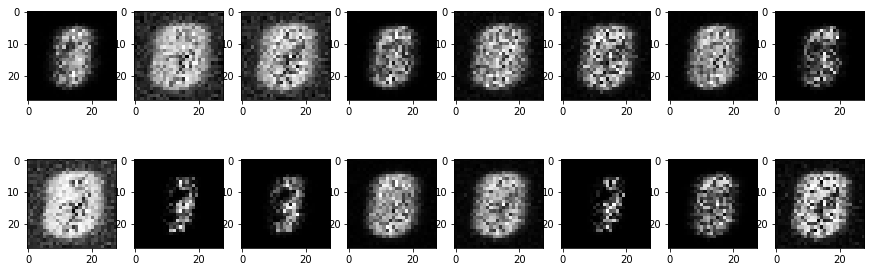

tensor(0.0797, device='cuda:0', grad_fn=<DivBackward0>)


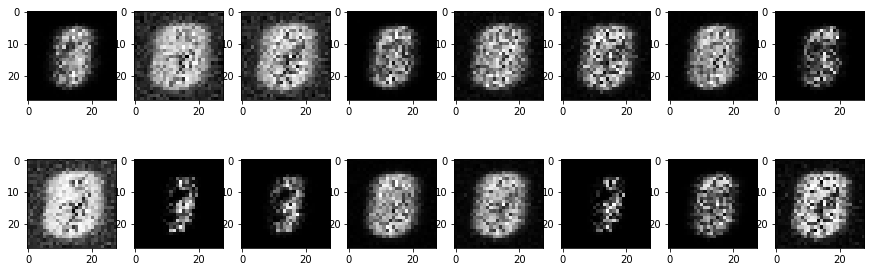

tensor(0.0725, device='cuda:0', grad_fn=<DivBackward0>)


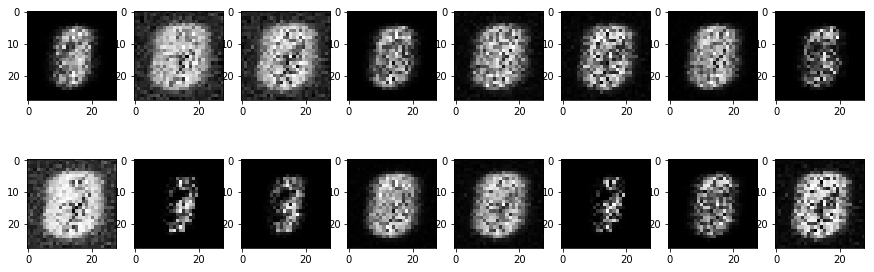

tensor(0.0842, device='cuda:0', grad_fn=<DivBackward0>)


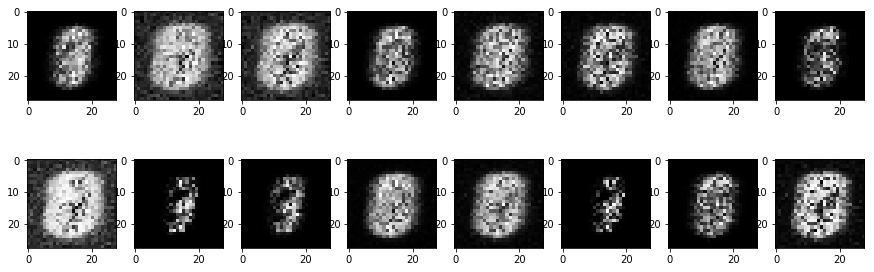

tensor(0.0829, device='cuda:0', grad_fn=<DivBackward0>)


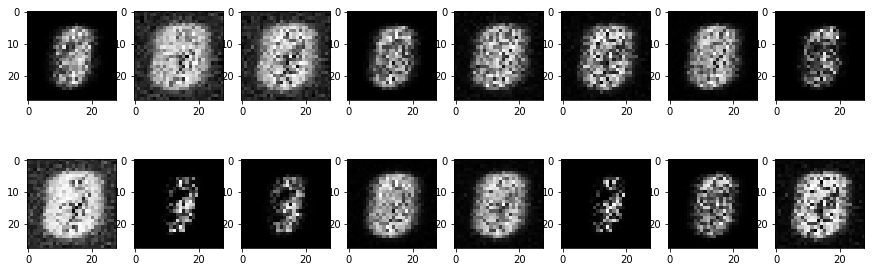

tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>)


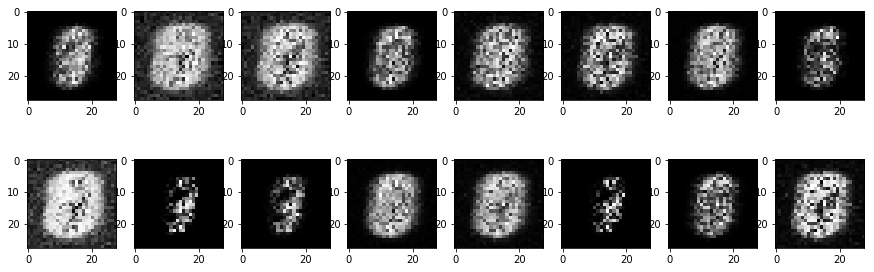

tensor(0.0783, device='cuda:0', grad_fn=<DivBackward0>)


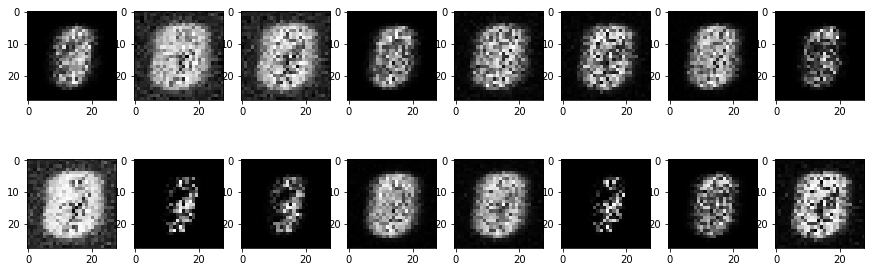

tensor(0.0837, device='cuda:0', grad_fn=<DivBackward0>)


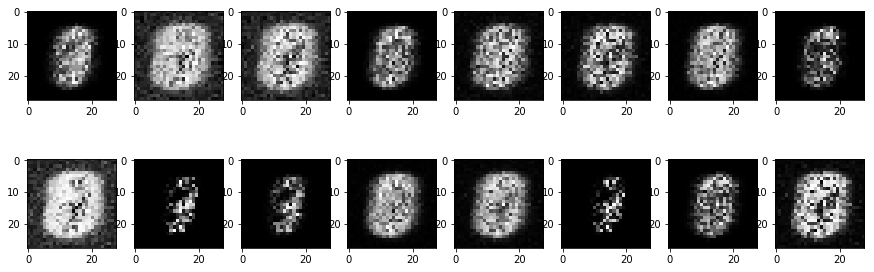

tensor(0.0761, device='cuda:0', grad_fn=<DivBackward0>)


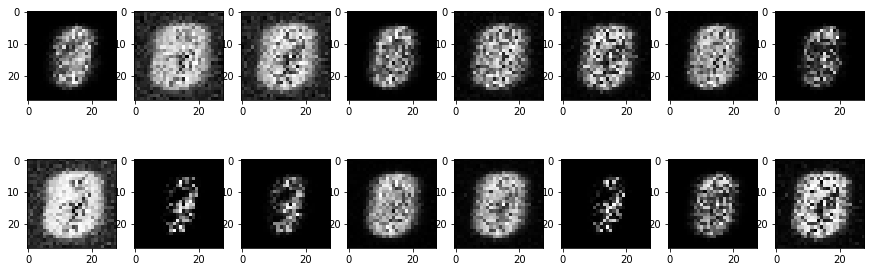

tensor(0.0731, device='cuda:0', grad_fn=<DivBackward0>)


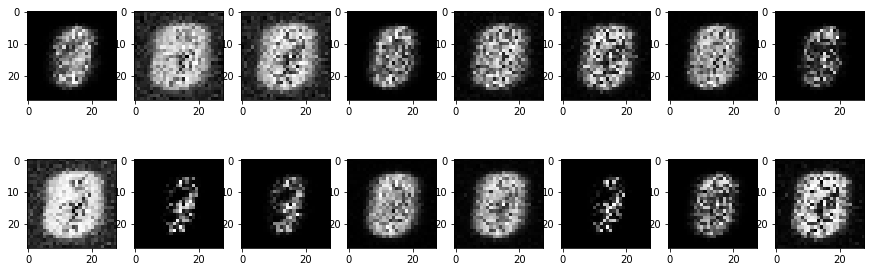

tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)


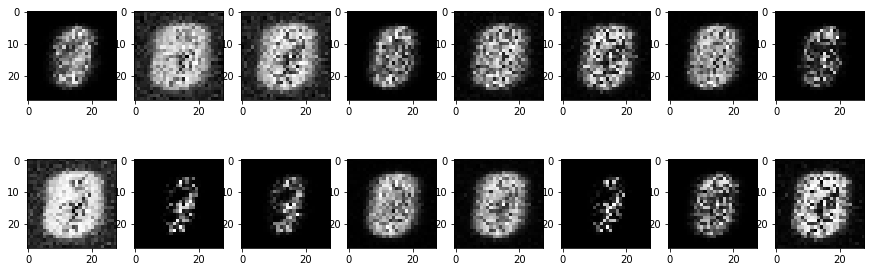

tensor(0.0709, device='cuda:0', grad_fn=<DivBackward0>)


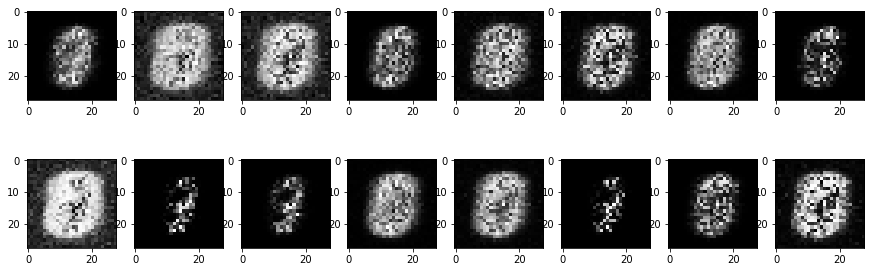

tensor(0.0785, device='cuda:0', grad_fn=<DivBackward0>)


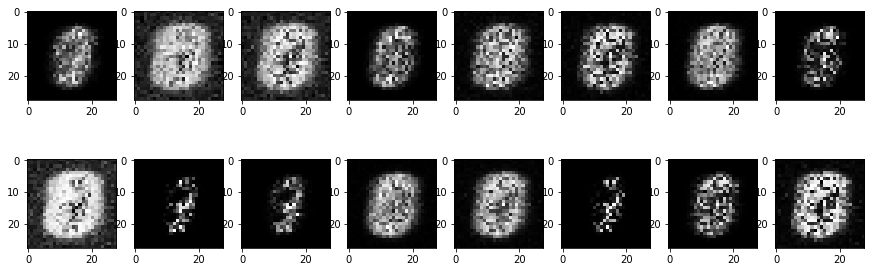

tensor(0.0759, device='cuda:0', grad_fn=<DivBackward0>)


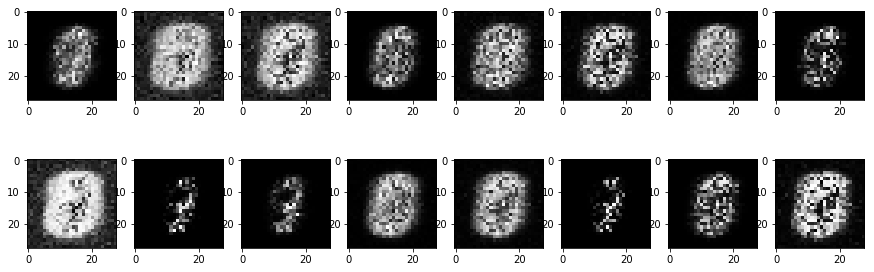

tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)


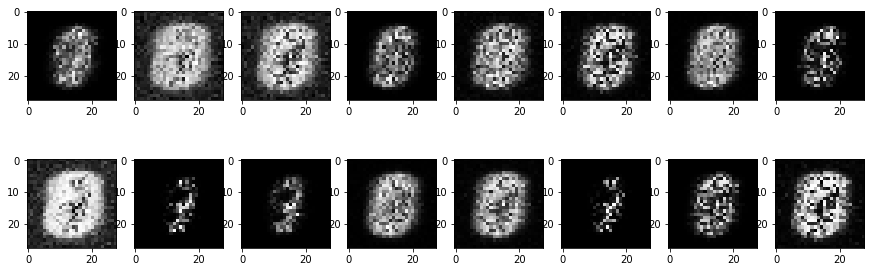

tensor(0.0789, device='cuda:0', grad_fn=<DivBackward0>)


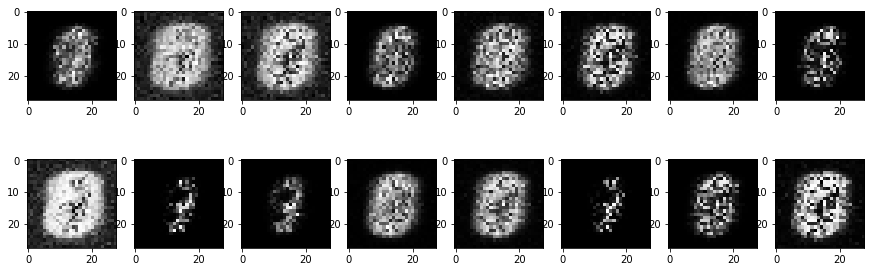

tensor(0.0742, device='cuda:0', grad_fn=<DivBackward0>)


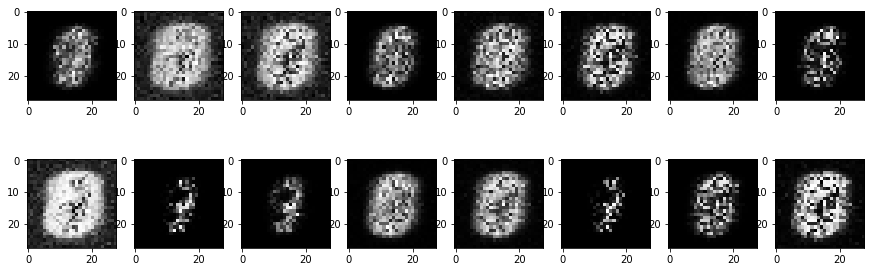

tensor(0.0684, device='cuda:0', grad_fn=<DivBackward0>)


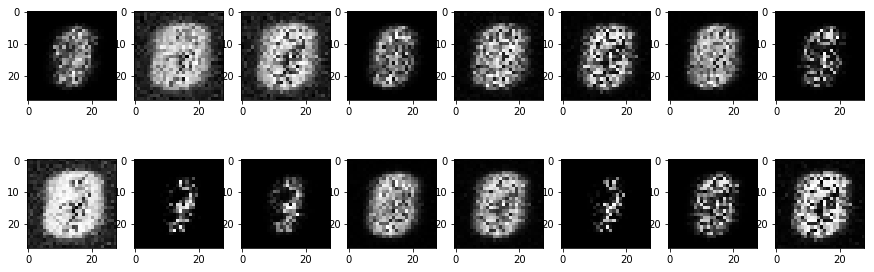

tensor(0.0705, device='cuda:0', grad_fn=<DivBackward0>)


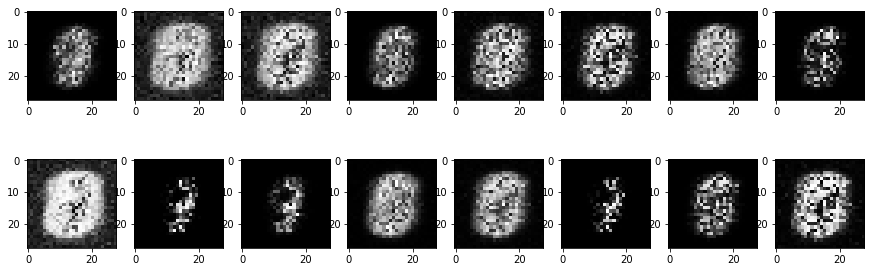

tensor(0.0668, device='cuda:0', grad_fn=<DivBackward0>)


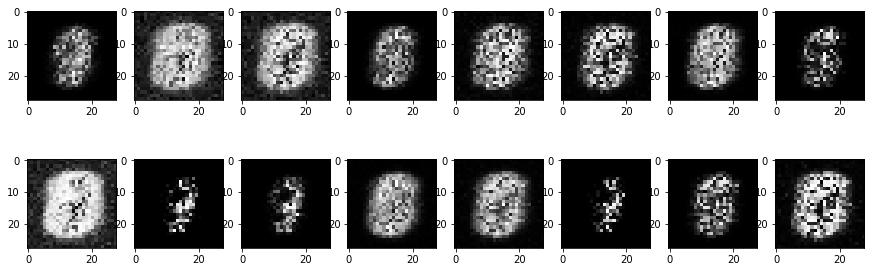

tensor(0.0683, device='cuda:0', grad_fn=<DivBackward0>)


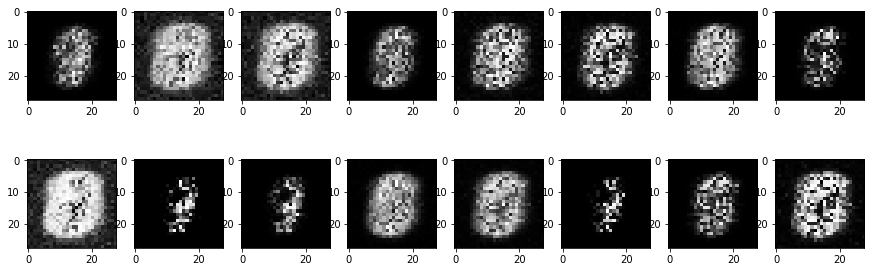

tensor(0.0647, device='cuda:0', grad_fn=<DivBackward0>)


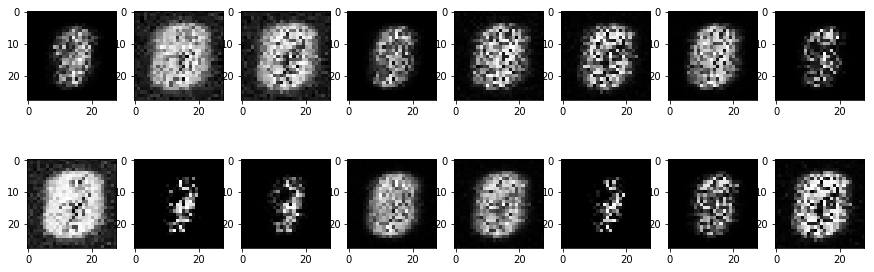

tensor(0.0638, device='cuda:0', grad_fn=<DivBackward0>)


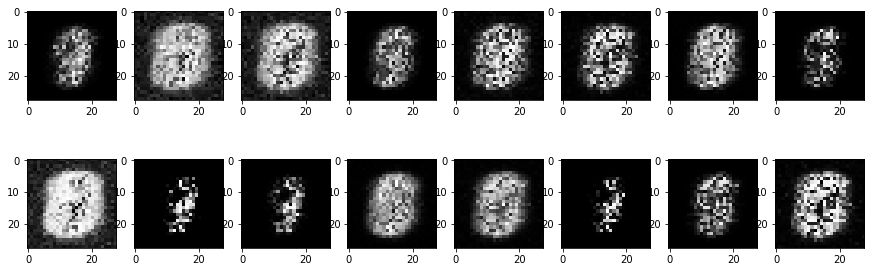

tensor(0.0645, device='cuda:0', grad_fn=<DivBackward0>)


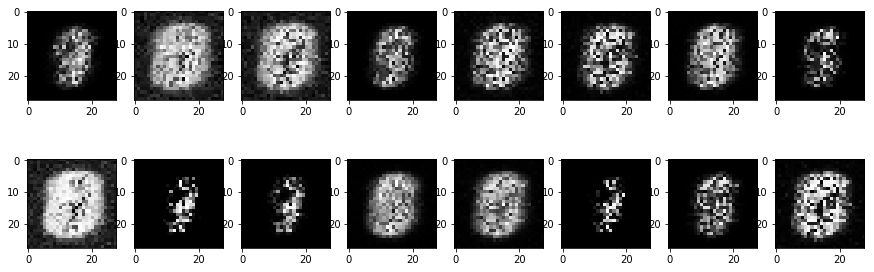

tensor(0.0613, device='cuda:0', grad_fn=<DivBackward0>)


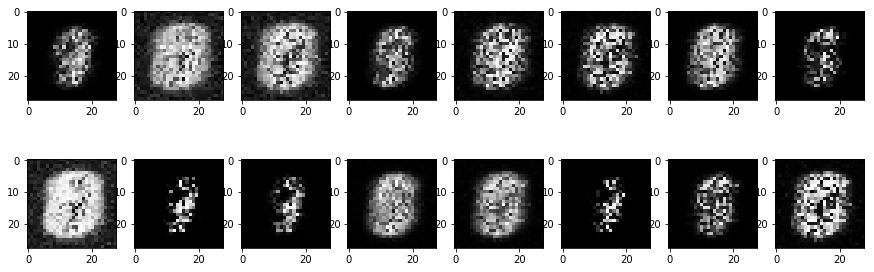

tensor(0.0641, device='cuda:0', grad_fn=<DivBackward0>)


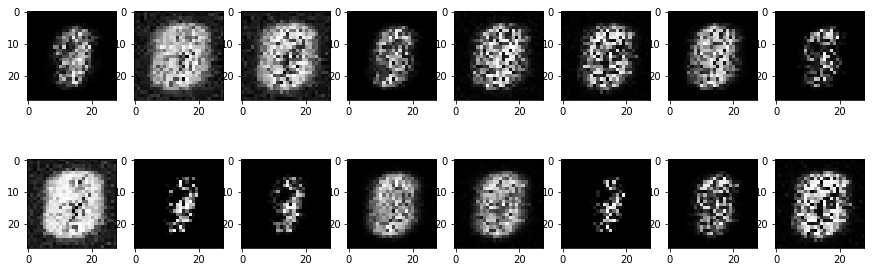

tensor(0.0658, device='cuda:0', grad_fn=<DivBackward0>)


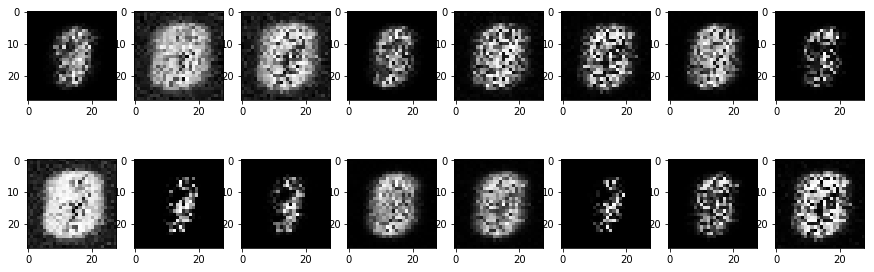

tensor(0.0616, device='cuda:0', grad_fn=<DivBackward0>)


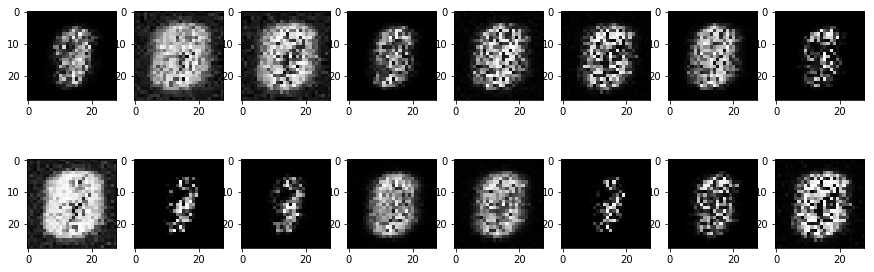

tensor(0.0617, device='cuda:0', grad_fn=<DivBackward0>)


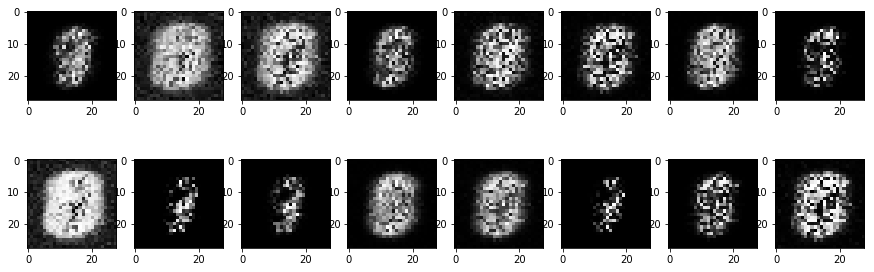

tensor(0.0647, device='cuda:0', grad_fn=<DivBackward0>)


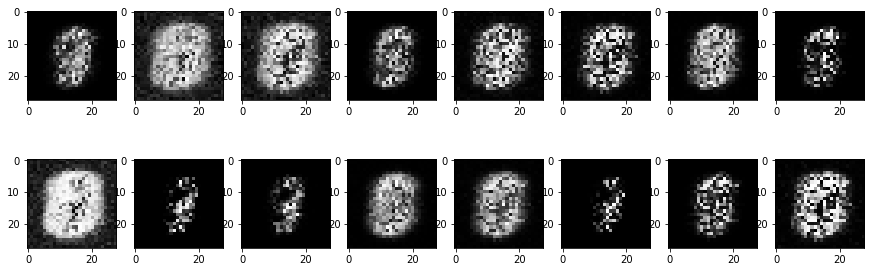

tensor(0.0629, device='cuda:0', grad_fn=<DivBackward0>)


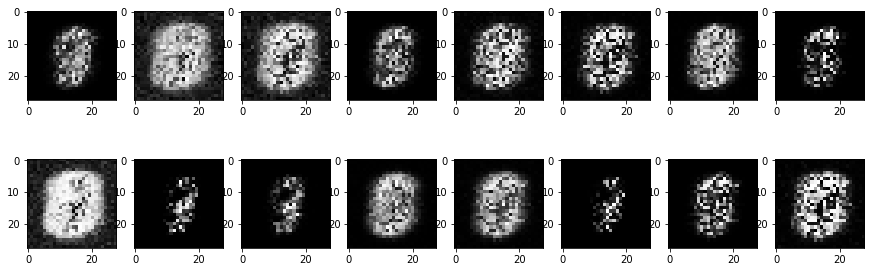

tensor(0.0694, device='cuda:0', grad_fn=<DivBackward0>)


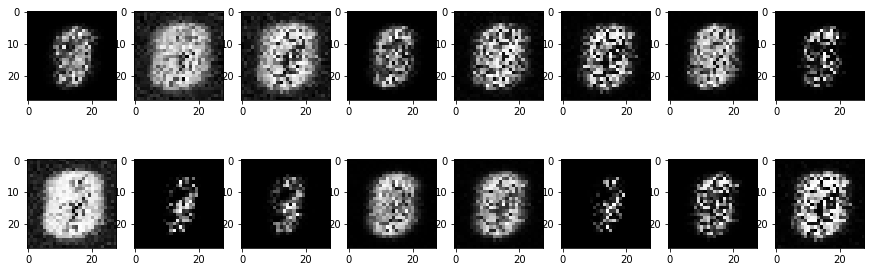

tensor(0.0556, device='cuda:0', grad_fn=<DivBackward0>)


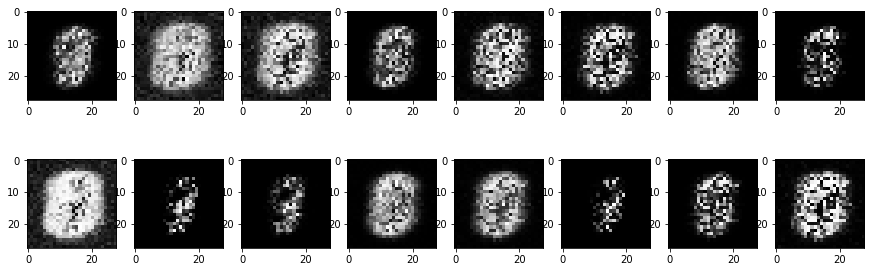

tensor(0.0569, device='cuda:0', grad_fn=<DivBackward0>)


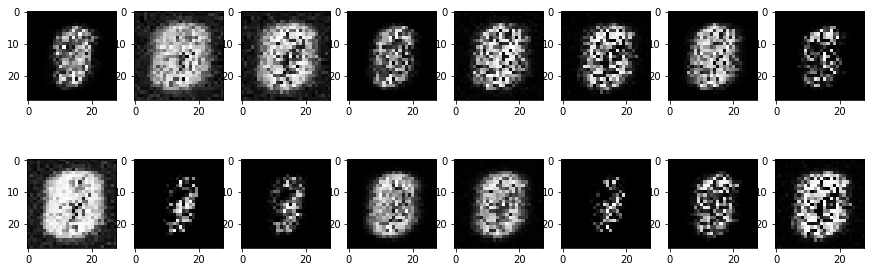

tensor(0.0642, device='cuda:0', grad_fn=<DivBackward0>)


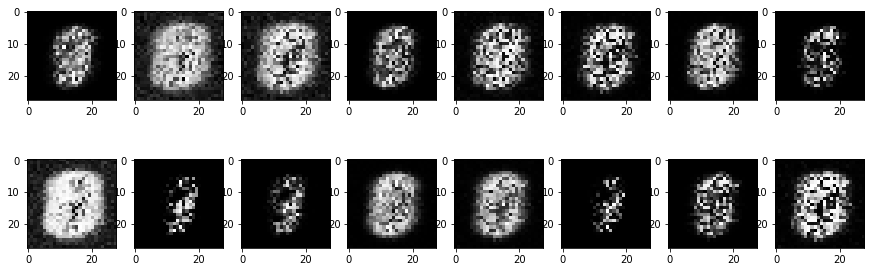

tensor(0.0532, device='cuda:0', grad_fn=<DivBackward0>)


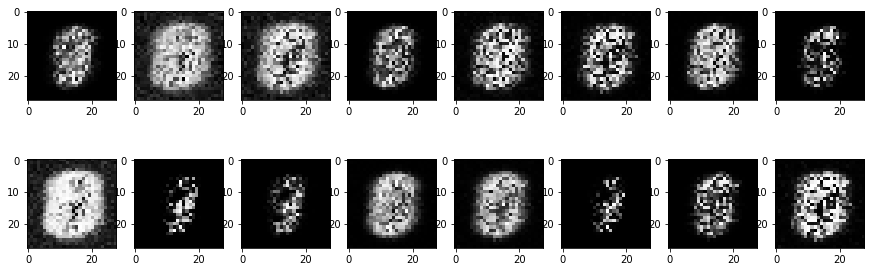

tensor(0.0574, device='cuda:0', grad_fn=<DivBackward0>)


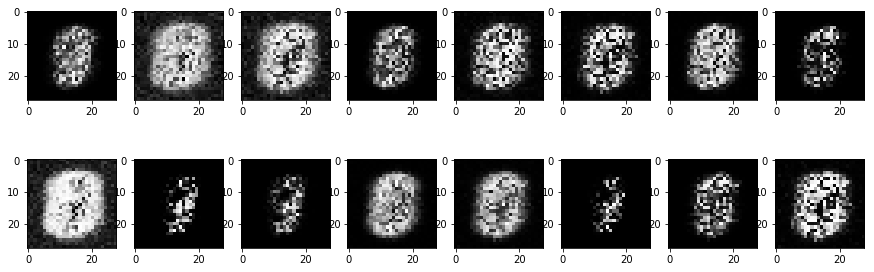

tensor(0.0608, device='cuda:0', grad_fn=<DivBackward0>)


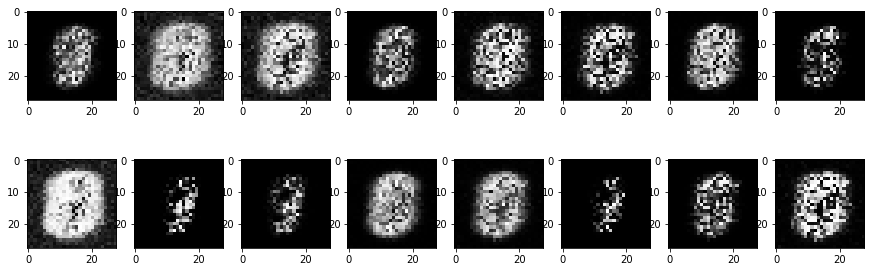

tensor(0.0619, device='cuda:0', grad_fn=<DivBackward0>)


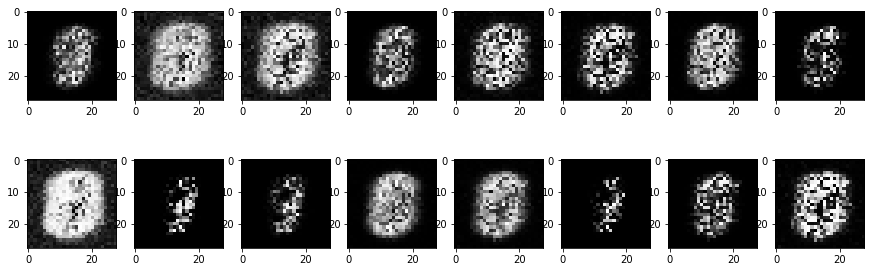

tensor(0.0568, device='cuda:0', grad_fn=<DivBackward0>)


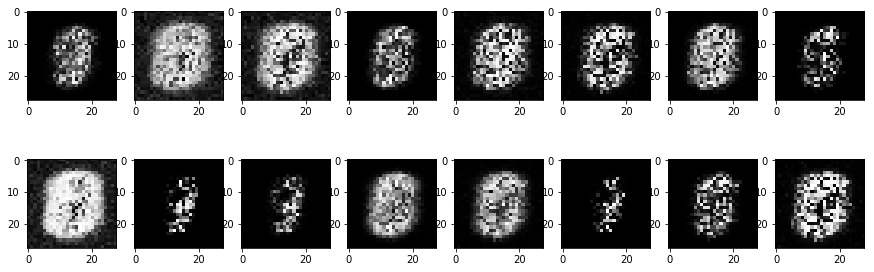

tensor(0.0555, device='cuda:0', grad_fn=<DivBackward0>)


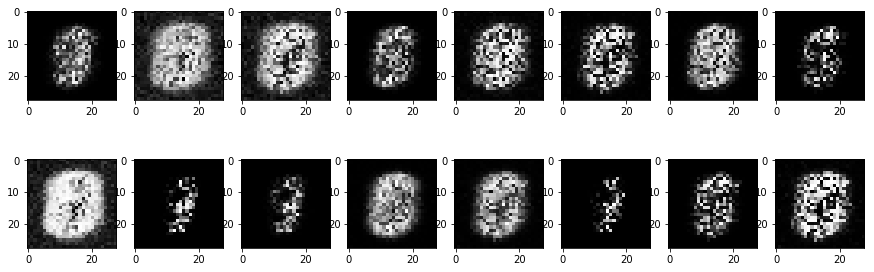

RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1549630534704/work/aten/src/THC/generic/THCTensorMathPointwise.cu:351

In [122]:
# Create logger instance
#logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in (range(num_epochs)):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        #print("number of batch is",n_batch)
        #print(real_batch.shape)
        N = real_batch.size(0)
        
        # 1. Train Discriminator
#         for _ in range(5):
#             real_data = Variable(images_to_vectors(real_batch))
#             # Generate fake data and detach 
#             # (so gradients are not calculated for generator)
#             fake_data = generator(noise(N)).detach() #or generator.forward(noise(N))
#             # Train D
#             d_error, d_pred_real, d_pred_fake = \
#                   train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        #Generate real data
        real_data = Variable(images_to_vectors(real_batch)).cuda()
        
        # Generate fake data
        fake_data = generator(noise(N))
        #print(fake_data[0][0])
        #print(fake_data.shape)
        # Train G
        g_error = train_generator(g_optimizer, real_data, fake_data)
        print(g_error)
        # Log batch error
        #logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        
        if (n_batch) % 1 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = (test_images.data).cpu()
            #print(test_images)
            plt.figure(figsize=(15,5))
            #plt.subplots_adjust(hspace=0)
            for i in (range(16)):
                plt.subplot(2,8,i+1)
                plt.imshow(test_images[i][0],cmap='gray')
            plt.show()
            '''logger.log_images(
                test_images, num_test_samples, 
           
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )'''

In [ ]:
torch.cuda.empty_cache();